## Imports & Setup

In [1]:
import os
import random
import numpy as np
import pandas as pd
import pydicom
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)

from torchvision import transforms
from transformers import ViTForImageClassification

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Dataset Class & Transforms

In [2]:
class CustomMedicalImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            dcm = pydicom.dcmread(self.image_paths[idx])
            arr = dcm.pixel_array.astype(np.float32)
            img = Image.fromarray((arr/arr.max()*255).astype(np.uint8)).convert("RGB")
            if self.transform:
                img = self.transform(img)
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return img, label
        except Exception as e:
            print(f"Error reading {self.image_paths[idx]}: {e}")
            raise e

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

## Load Paths & Labels

In [3]:
image_dir = "/mnt/e/ecs289l/mimic-cxr-download/imageData/"
all_paths = []
for root, _, files in os.walk(image_dir):
    for f in files:
        if f.endswith(".dcm"):
            all_paths.append(os.path.join(root, f))

meta = pd.read_csv(
    "../download_data/metadata/edema+pleural_effusion_samples_v2.csv",
    dtype={'study_id': str}
)
meta['study_id'] = 's' + meta['study_id']
label_map = meta.set_index('study_id')[['edema','effusion']].to_dict(orient='index')

paths, labels = [], []
for p in all_paths:
    sid = os.path.basename(os.path.dirname(p))
    if sid in label_map:
        paths.append(p)
        labels.append([label_map[sid]['edema'], label_map[sid]['effusion']])
labels = np.array(labels)
print(f"Total samples: {len(paths)}")

Total samples: 7199


## Split

In [4]:
train_data, test_val_data, train_labels, test_val_labels = train_test_split(
    paths, labels, test_size=0.3, random_state=SEED, shuffle=True, stratify=labels
)
test_data, val_data, test_labels, val_labels = train_test_split(
    test_val_data, test_val_labels, test_size=1/3, random_state=SEED, shuffle=True, stratify=test_val_labels
)

print("Train / Val / Test sizes:", len(train_data), len(val_data), len(test_data))

train_ds = CustomMedicalImageDataset(train_data, train_labels, transform=transform)
val_ds = CustomMedicalImageDataset(val_data, val_labels, transform=transform)
test_ds = CustomMedicalImageDataset(test_data, test_labels, transform=transform)

Train / Val / Test sizes: 5039 720 1440


## Training

In [5]:
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for imgs, labs in tqdm(loader, desc="Training"):
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        logits = model(imgs).logits
        loss = criterion(logits, labs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for imgs, labs in tqdm(loader, desc="Validation"):
            imgs, labs = imgs.to(device), labs.to(device)
            logits = model(imgs).logits
            total_loss += criterion(logits, labs).item()
    return total_loss / len(loader)


def run_training(combo, train_loader, val_loader, model, device):
    # Unpack combo
    dp, wd, lr = combo['dropout_rate'], combo['weight_decay'], combo['learning_rate']
    ne, pt  = combo['num_epochs'], combo.get('patience', 5)

    # Configure model, loss, optimizer
    model.config.classifier_dropout = dp
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    best_val_loss = float('inf')
    no_improve = 0

    for epoch in range(1, ne+1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch}/{ne}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= pt:
                print(f"Early stopping at epoch {epoch}")
                break

## Evaluation

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm

import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for imgs, labs in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device)
            logits = model(imgs).logits.cpu().numpy()
            probs = torch.sigmoid(torch.tensor(logits)).numpy()
            all_probs.append(probs)
            all_labels.append(labs.numpy())
    all_probs  = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)
    preds = (all_probs >= 0.5).astype(int)

    metrics = {}
    for i, name in enumerate(['edema','effusion']):
        y_true = all_labels[:,i]
        y_pred = preds[:,i]
        y_prob = all_probs[:,i]
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auroc = roc_auc_score(y_true, y_prob)
        auprc = average_precision_score(y_true, y_prob)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp/(tp+fn)
        spec = tn/(tn+fp)
        metrics[name] = {
            'precision': precision, 'recall': recall,
            'f1': f1, 'auroc': auroc,
            'auprc': auprc, 'sensitivity': sens,
            'specificity': spec
        }
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred))
        disp.plot()
        plt.title(f'Confusion Matrix: {name}')
        plt.show()
    return metrics

## Execute Hyperparameter Combinations

In [7]:
import json

hyperparameter_combinations = []
for dropout_rate in [0.1, 0.2]:
    for weight_decay in [0, 0.01, 0.1]:
        for learning_rate in [1e-5, 5e-5, 2e-4]:
            for batch_size in [16, 32, 64]:
                for num_epochs in [20]:
                    hyperparameter_combinations.append({
                        'dropout_rate': dropout_rate,
                        'weight_decay': weight_decay,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'num_epochs': num_epochs
                    })

combo_results = []

def execute_hyperparameter_combinations(combo):
    # Unpack combo
    dp, wd, lr, bs = combo['dropout_rate'], combo['weight_decay'], combo['learning_rate'], combo['batch_size']
    name = f"dp{dp}_wd{wd}_lr{lr}_bs{bs}"
    print(f"Running combination: {name}")

    # Create DataLoader with current batch size
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)
    test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

    # Load model
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=2
    ).to(device)

    # Run training
    run_training(combo, train_loader, val_loader, model, device)

    # Evaluate model
    metrics = evaluate_model(model, test_loader, device)
    print(f"Metrics for {name}: {metrics}")
    combo_results.append({
        'name': name,
        'combo': combo,
        'metrics': metrics
    })

    # Save results
    with open("results.json", "r") as f:
        results = json.load(f)
    results.append({
        'name': name,
        'combo': combo,
        'metrics': metrics
    })
    with open("results.json", "w") as f:
        json.dump(results, f, indent=4)

Running combination: dp0.1_wd0_lr1e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it]


Epoch 1/30: train_loss=0.5171, val_loss=0.4781


Validation: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


Epoch 2/30: train_loss=0.4000, val_loss=0.4203


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 3/30: train_loss=0.3690, val_loss=0.4183


Validation: 100%|██████████| 45/45 [00:43<00:00,  1.05it/s]


Epoch 4/30: train_loss=0.3484, val_loss=0.3992


Validation: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


Epoch 5/30: train_loss=0.3323, val_loss=0.3962


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 6/30: train_loss=0.3137, val_loss=0.3871


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 7/30: train_loss=0.3038, val_loss=0.4036


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]


Epoch 8/30: train_loss=0.2844, val_loss=0.3929


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 9/30: train_loss=0.2710, val_loss=0.3990


Validation: 100%|██████████| 45/45 [00:43<00:00,  1.05it/s]


Epoch 10/30: train_loss=0.2600, val_loss=0.3967


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]

Epoch 11/30: train_loss=0.2455, val_loss=0.4138
Early stopping at epoch 11


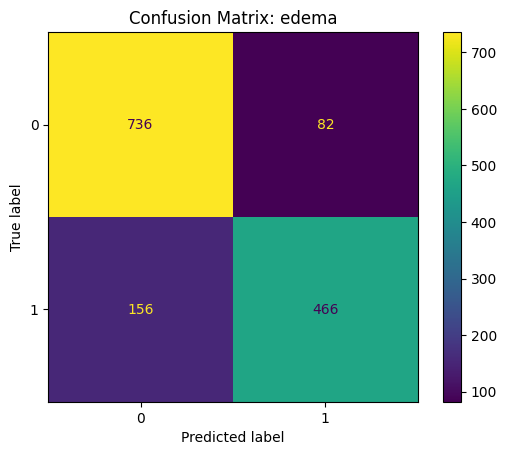

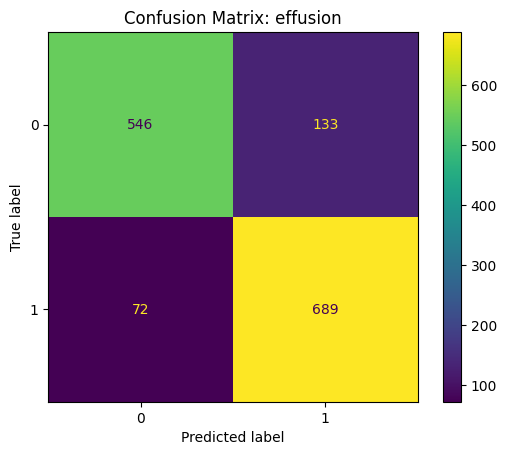

Metrics for dp0.1_wd0_lr1e-05_bs16: {'edema': {'precision': 0.8503649635036497, 'recall': 0.7491961414790996, 'f1': 0.7965811965811965, 'auroc': 0.9110881374853576, 'auprc': 0.8917649545507675, 'sensitivity': 0.7491961414790996, 'specificity': 0.8997555012224939}, 'effusion': {'precision': 0.8381995133819952, 'recall': 0.9053876478318003, 'f1': 0.8704990524320909, 'auroc': 0.9324100720120607, 'auprc': 0.9384489346758536, 'sensitivity': 0.9053876478318003, 'specificity': 0.8041237113402062}}
Running combination: dp0.1_wd0_lr1e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 1/30: train_loss=0.5579, val_loss=0.4815


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 2/30: train_loss=0.4259, val_loss=0.4383


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 3/30: train_loss=0.3888, val_loss=0.4194


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.88s/it]


Epoch 4/30: train_loss=0.3629, val_loss=0.4081


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 5/30: train_loss=0.3440, val_loss=0.4131


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 6/30: train_loss=0.3319, val_loss=0.3982


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 7/30: train_loss=0.3165, val_loss=0.4274


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 8/30: train_loss=0.3046, val_loss=0.3914


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 9/30: train_loss=0.2963, val_loss=0.4055


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 10/30: train_loss=0.2806, val_loss=0.3986


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 11/30: train_loss=0.2723, val_loss=0.4027


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 12/30: train_loss=0.2580, val_loss=0.3911


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 13/30: train_loss=0.2519, val_loss=0.3919


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 14/30: train_loss=0.2350, val_loss=0.4506


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 15/30: train_loss=0.2275, val_loss=0.3953


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 16/30: train_loss=0.2224, val_loss=0.4041


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]

Epoch 17/30: train_loss=0.2062, val_loss=0.4093
Early stopping at epoch 17


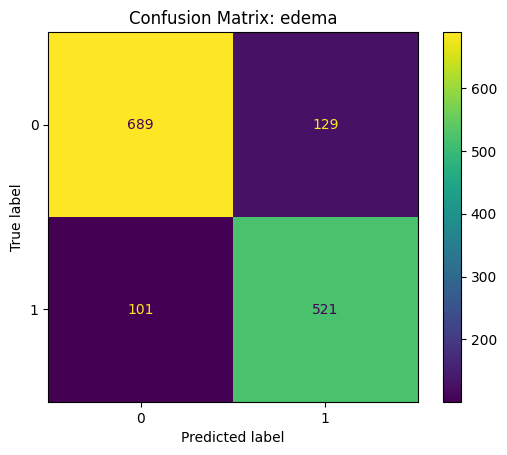

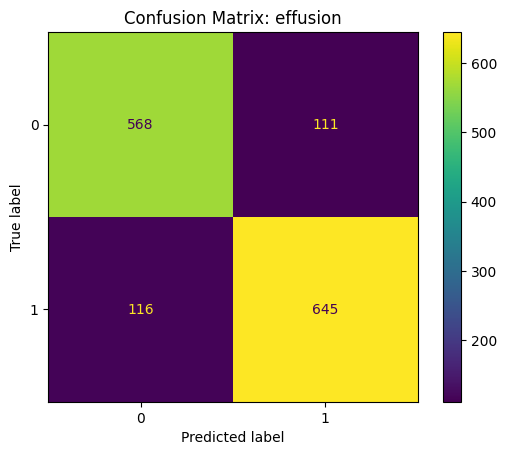

Metrics for dp0.1_wd0_lr1e-05_bs32: {'edema': {'precision': 0.8015384615384615, 'recall': 0.837620578778135, 'f1': 0.8191823899371069, 'auroc': 0.9127292667395185, 'auprc': 0.8874252686295385, 'sensitivity': 0.837620578778135, 'specificity': 0.8422982885085575}, 'effusion': {'precision': 0.8531746031746031, 'recall': 0.8475689881734559, 'f1': 0.8503625576796309, 'auroc': 0.9269912660459553, 'auprc': 0.9279207322708914, 'sensitivity': 0.8475689881734559, 'specificity': 0.8365243004418262}}
Running combination: dp0.1_wd0_lr1e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]


Epoch 1/30: train_loss=0.5718, val_loss=0.5053


Validation: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]


Epoch 2/30: train_loss=0.4445, val_loss=0.4573


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.98s/it]


Epoch 3/30: train_loss=0.4084, val_loss=0.4347


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.65s/it]


Epoch 4/30: train_loss=0.3852, val_loss=0.4250


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.66s/it]


Epoch 5/30: train_loss=0.3692, val_loss=0.4176


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.59s/it]


Epoch 6/30: train_loss=0.3513, val_loss=0.4106


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.69s/it]


Epoch 7/30: train_loss=0.3401, val_loss=0.4057


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 8/30: train_loss=0.3251, val_loss=0.4085


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 9/30: train_loss=0.3138, val_loss=0.3923


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 10/30: train_loss=0.3034, val_loss=0.4184


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it]


Epoch 11/30: train_loss=0.2923, val_loss=0.3941


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it]


Epoch 12/30: train_loss=0.2861, val_loss=0.3873


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.62s/it]


Epoch 13/30: train_loss=0.2702, val_loss=0.3940


Validation: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it]


Epoch 14/30: train_loss=0.2606, val_loss=0.4116


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it]


Epoch 15/30: train_loss=0.2606, val_loss=0.4000


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.60s/it]


Epoch 16/30: train_loss=0.2449, val_loss=0.4020


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it]

Epoch 17/30: train_loss=0.2399, val_loss=0.4099
Early stopping at epoch 17


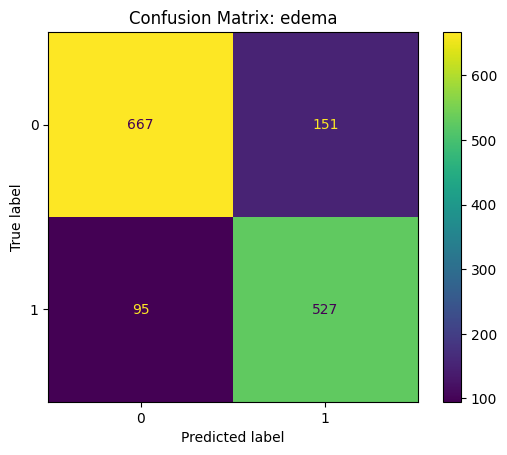

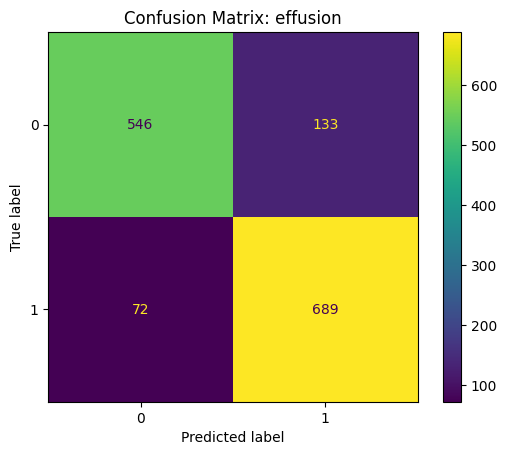

Metrics for dp0.1_wd0_lr1e-05_bs64: {'edema': {'precision': 0.7772861356932154, 'recall': 0.8472668810289389, 'f1': 0.8107692307692308, 'auroc': 0.9126280473903097, 'auprc': 0.8946176313447247, 'sensitivity': 0.8472668810289389, 'specificity': 0.815403422982885}, 'effusion': {'precision': 0.8381995133819952, 'recall': 0.9053876478318003, 'f1': 0.8704990524320909, 'auroc': 0.9287156075158837, 'auprc': 0.9299832572618092, 'sensitivity': 0.9053876478318003, 'specificity': 0.8041237113402062}}


In [19]:
for i in range(0, 3):
    hyperparameters = hyperparameter_combinations[i]
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.1_wd0_lr5e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 1/20: train_loss=0.4621, val_loss=0.4453


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 2/20: train_loss=0.3737, val_loss=0.4111


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 3/20: train_loss=0.3434, val_loss=0.4118


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 4/20: train_loss=0.3169, val_loss=0.4277


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 5/20: train_loss=0.3058, val_loss=0.3869


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 6/20: train_loss=0.2795, val_loss=0.3852


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 7/20: train_loss=0.2538, val_loss=0.4028


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 8/20: train_loss=0.2384, val_loss=0.3820


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 9/20: train_loss=0.2147, val_loss=0.3745


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 10/20: train_loss=0.1967, val_loss=0.4234


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 11/20: train_loss=0.1699, val_loss=0.4762


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 12/20: train_loss=0.1488, val_loss=0.4897


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 13/20: train_loss=0.1220, val_loss=0.5029


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 14/20: train_loss=0.1201, val_loss=0.5058
Early stopping at epoch 14


Evaluating: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s]


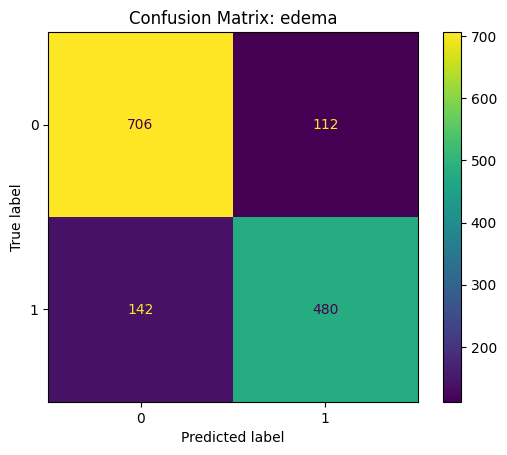

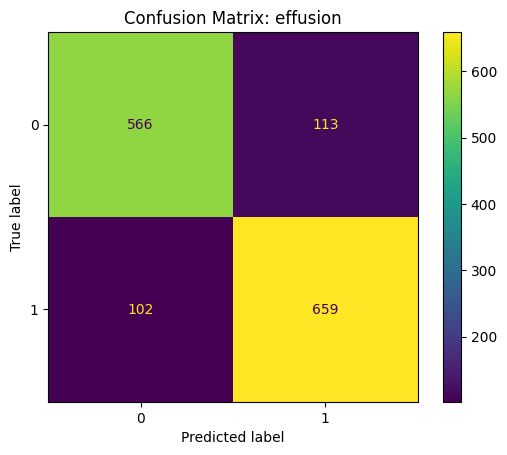

Metrics for dp0.1_wd0_lr5e-05_bs16: {'edema': {'precision': 0.8108108108108109, 'recall': 0.7717041800643086, 'f1': 0.7907742998352554, 'auroc': 0.9024894063632576, 'auprc': 0.8701143291850439, 'sensitivity': 0.7717041800643086, 'specificity': 0.863080684596577}, 'effusion': {'precision': 0.8536269430051814, 'recall': 0.8659658344283837, 'f1': 0.8597521200260926, 'auroc': 0.920850597713651, 'auprc': 0.9177657312421342, 'sensitivity': 0.8659658344283837, 'specificity': 0.833578792341679}}
Running combination: dp0.1_wd0_lr5e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 1/20: train_loss=0.4734, val_loss=0.4590


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 2/20: train_loss=0.3833, val_loss=0.4108


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 3/20: train_loss=0.3469, val_loss=0.4639


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 4/20: train_loss=0.3376, val_loss=0.4205


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 5/20: train_loss=0.3090, val_loss=0.3867


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 6/20: train_loss=0.2847, val_loss=0.4101


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 7/20: train_loss=0.2725, val_loss=0.3942


Validation: 100%|██████████| 23/23 [00:38<00:00,  1.68s/it]


Epoch 8/20: train_loss=0.2485, val_loss=0.4151


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 9/20: train_loss=0.2380, val_loss=0.4175


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.70s/it]


Epoch 10/20: train_loss=0.2070, val_loss=0.4313
Early stopping at epoch 10


Evaluating: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


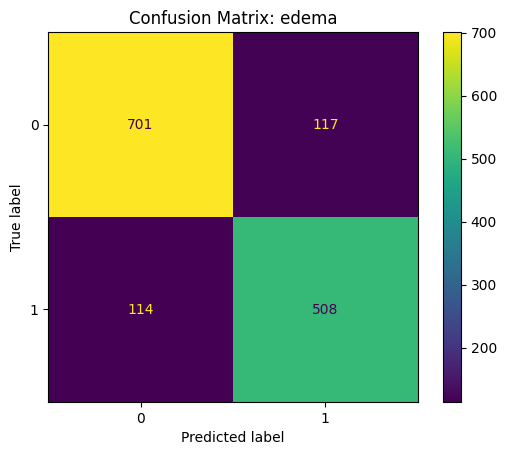

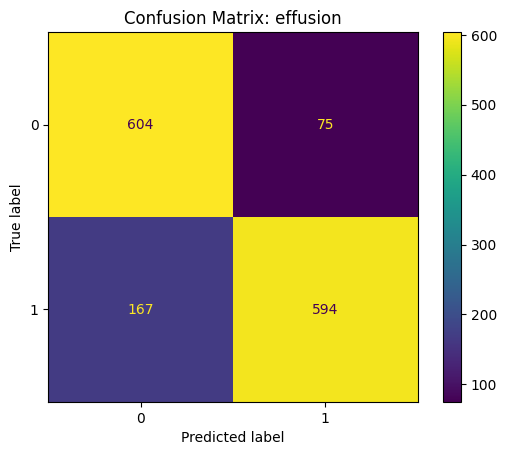

Metrics for dp0.1_wd0_lr5e-05_bs32: {'edema': {'precision': 0.8128, 'recall': 0.8167202572347267, 'f1': 0.8147554129911788, 'auroc': 0.9109348343933521, 'auprc': 0.886213888704434, 'sensitivity': 0.8167202572347267, 'specificity': 0.8569682151589242}, 'effusion': {'precision': 0.8878923766816144, 'recall': 0.7805519053876478, 'f1': 0.8307692307692308, 'auroc': 0.9286033608208717, 'auprc': 0.9286035233797112, 'sensitivity': 0.7805519053876478, 'specificity': 0.8895434462444771}}
Running combination: dp0.1_wd0_lr5e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:44<00:00,  3.75s/it]


Epoch 1/20: train_loss=0.4988, val_loss=0.4589


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]


Epoch 2/20: train_loss=0.3983, val_loss=0.4525


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.92s/it]


Epoch 3/20: train_loss=0.3622, val_loss=0.3953


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 4/20: train_loss=0.3330, val_loss=0.3978


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.92s/it]


Epoch 5/20: train_loss=0.3134, val_loss=0.4074


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.91s/it]


Epoch 6/20: train_loss=0.2974, val_loss=0.3991


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]


Epoch 7/20: train_loss=0.2784, val_loss=0.4239


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.89s/it]


Epoch 8/20: train_loss=0.2727, val_loss=0.4046
Early stopping at epoch 8


Evaluating: 100%|██████████| 23/23 [01:30<00:00,  3.92s/it]


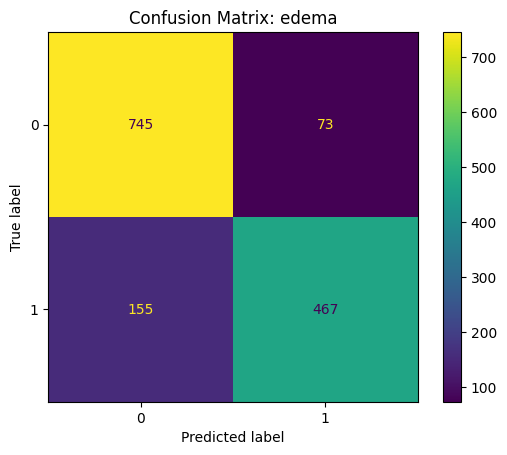

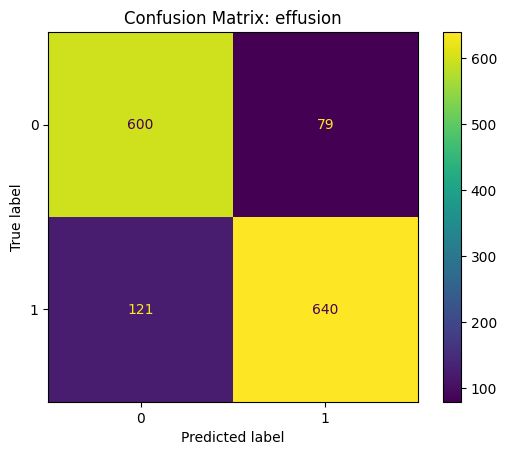

Metrics for dp0.1_wd0_lr5e-05_bs64: {'edema': {'precision': 0.8648148148148148, 'recall': 0.7508038585209004, 'f1': 0.8037865748709122, 'auroc': 0.9172006069230105, 'auprc': 0.8968319348600273, 'sensitivity': 0.7508038585209004, 'specificity': 0.910757946210269}, 'effusion': {'precision': 0.8901251738525731, 'recall': 0.8409986859395532, 'f1': 0.8648648648648649, 'auroc': 0.9369947689169548, 'auprc': 0.9415065567029717, 'sensitivity': 0.8409986859395532, 'specificity': 0.8836524300441826}}


In [8]:
for i in range(3, 6):
    hyperparameters = hyperparameter_combinations[i]
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.1_wd0_lr0.0002_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 1/20: train_loss=0.5191, val_loss=0.4830


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 2/20: train_loss=0.4493, val_loss=0.4881


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 3/20: train_loss=0.4191, val_loss=0.5186


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 4/20: train_loss=0.4148, val_loss=0.4176


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


Epoch 5/20: train_loss=0.3973, val_loss=0.4508


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 6/20: train_loss=0.3848, val_loss=0.4435


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


Epoch 7/20: train_loss=0.3739, val_loss=0.4350


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 8/20: train_loss=0.3694, val_loss=0.4065


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


Epoch 9/20: train_loss=0.3690, val_loss=0.4118


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 10/20: train_loss=0.3568, val_loss=0.4288


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 11/20: train_loss=0.3469, val_loss=0.4092


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 12/20: train_loss=0.3444, val_loss=0.4100


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.10it/s]


Epoch 13/20: train_loss=0.3455, val_loss=0.4800
Early stopping at epoch 13


Evaluating: 100%|██████████| 90/90 [01:17<00:00,  1.16it/s]


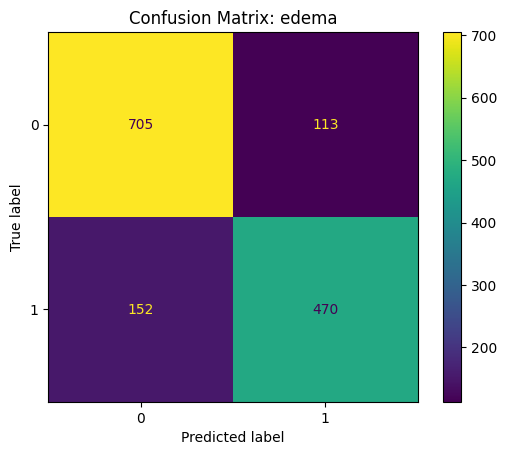

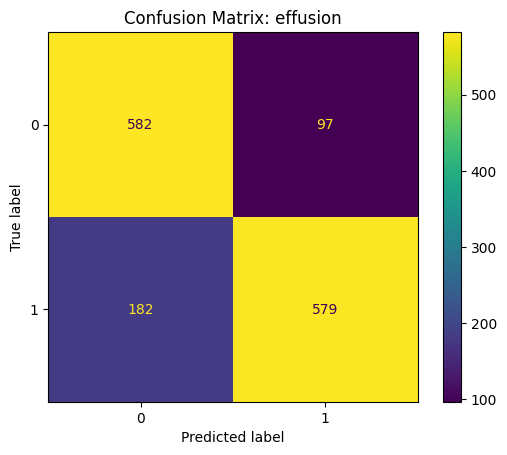

Metrics for dp0.1_wd0_lr0.0002_bs16: {'edema': {'precision': 0.8061749571183533, 'recall': 0.7556270096463023, 'f1': 0.7800829875518672, 'auroc': 0.8991973207336537, 'auprc': 0.8699331344487105, 'sensitivity': 0.7556270096463023, 'specificity': 0.8618581907090465}, 'effusion': {'precision': 0.856508875739645, 'recall': 0.7608409986859396, 'f1': 0.8058455114822547, 'auroc': 0.9055869824798392, 'auprc': 0.9167555470072406, 'sensitivity': 0.7608409986859396, 'specificity': 0.8571428571428571}}
Running combination: dp0.1_wd0_lr0.0002_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Epoch 1/20: train_loss=0.5510, val_loss=0.4951


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 2/20: train_loss=0.4483, val_loss=0.4595


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 3/20: train_loss=0.4075, val_loss=0.4408


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 4/20: train_loss=0.3896, val_loss=0.4809


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 5/20: train_loss=0.3821, val_loss=0.4207


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 6/20: train_loss=0.3612, val_loss=0.4045


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 7/20: train_loss=0.3557, val_loss=0.4475


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.83s/it]


Epoch 8/20: train_loss=0.3356, val_loss=0.4026


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 9/20: train_loss=0.3334, val_loss=0.4138


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 10/20: train_loss=0.3282, val_loss=0.4079


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.83s/it]


Epoch 11/20: train_loss=0.3210, val_loss=0.4266


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 12/20: train_loss=0.3033, val_loss=0.4437


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 13/20: train_loss=0.2973, val_loss=0.3837


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 14/20: train_loss=0.2870, val_loss=0.4260


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 15/20: train_loss=0.2794, val_loss=0.3902


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.83s/it]


Epoch 16/20: train_loss=0.2696, val_loss=0.3975


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 17/20: train_loss=0.2564, val_loss=0.4430


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 18/20: train_loss=0.2501, val_loss=0.4072
Early stopping at epoch 18


Evaluating: 100%|██████████| 45/45 [01:20<00:00,  1.78s/it]


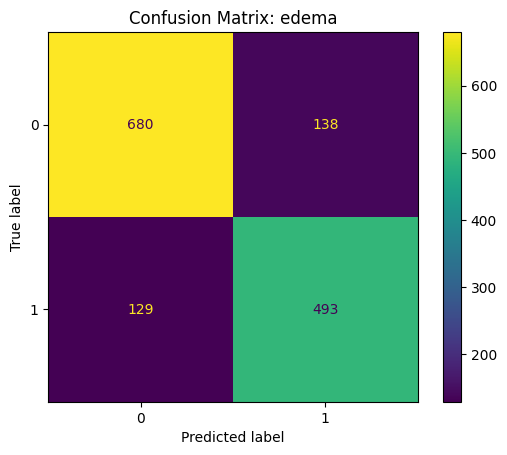

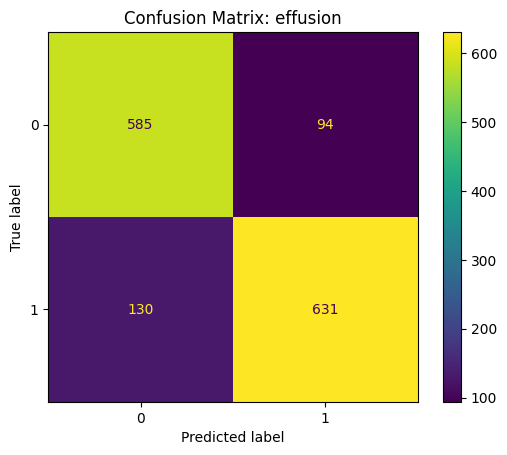

Metrics for dp0.1_wd0_lr0.0002_bs32: {'edema': {'precision': 0.7812995245641838, 'recall': 0.792604501607717, 'f1': 0.7869114126097366, 'auroc': 0.8949716585822216, 'auprc': 0.8567741098371972, 'sensitivity': 0.792604501607717, 'specificity': 0.8312958435207825}, 'effusion': {'precision': 0.8703448275862069, 'recall': 0.8291721419185283, 'f1': 0.8492597577388964, 'auroc': 0.9227162151962672, 'auprc': 0.9302622284749746, 'sensitivity': 0.8291721419185283, 'specificity': 0.8615611192930781}}
Running combination: dp0.1_wd0_lr0.0002_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it]


Epoch 1/20: train_loss=0.4993, val_loss=0.5160


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


Epoch 2/20: train_loss=0.4096, val_loss=0.4532


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 3/20: train_loss=0.3646, val_loss=0.4261


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.69s/it]


Epoch 4/20: train_loss=0.3527, val_loss=0.4418


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 5/20: train_loss=0.3287, val_loss=0.4039


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 6/20: train_loss=0.3189, val_loss=0.4421


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 7/20: train_loss=0.3123, val_loss=0.3691


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.69s/it]


Epoch 8/20: train_loss=0.2908, val_loss=0.4303


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.70s/it]


Epoch 9/20: train_loss=0.2876, val_loss=0.4228


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 10/20: train_loss=0.2717, val_loss=0.4275


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Epoch 11/20: train_loss=0.2641, val_loss=0.3816


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 12/20: train_loss=0.2444, val_loss=0.3921
Early stopping at epoch 12


Evaluating: 100%|██████████| 23/23 [01:22<00:00,  3.57s/it]


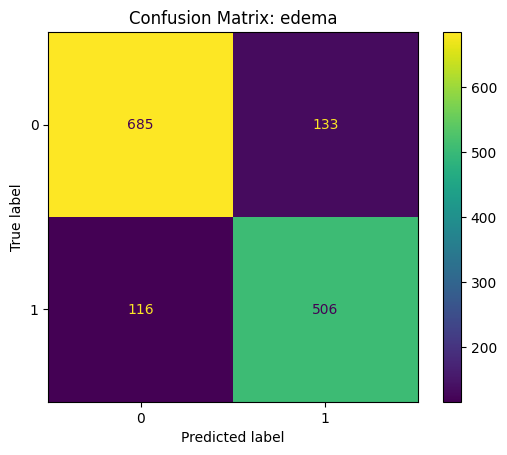

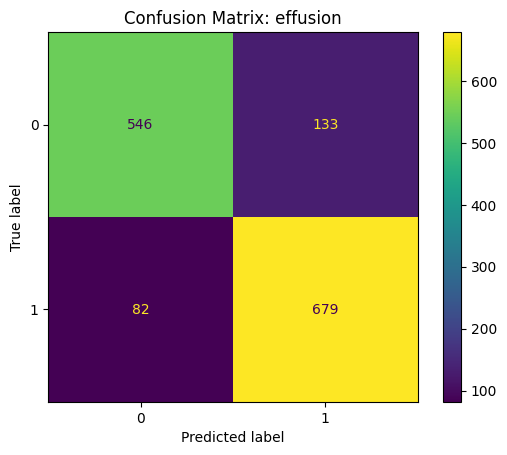

Metrics for dp0.1_wd0_lr0.0002_bs64: {'edema': {'precision': 0.7918622848200313, 'recall': 0.8135048231511254, 'f1': 0.80253766851705, 'auroc': 0.9062728480569815, 'auprc': 0.8715897253768915, 'sensitivity': 0.8135048231511254, 'specificity': 0.8374083129584352}, 'effusion': {'precision': 0.8362068965517241, 'recall': 0.8922470433639947, 'f1': 0.863318499682136, 'auroc': 0.9253056303329276, 'auprc': 0.9285128916444114, 'sensitivity': 0.8922470433639947, 'specificity': 0.8041237113402062}}


In [10]:
for i in range(6, 9):
    hyperparameters = hyperparameter_combinations[i]
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.1_wd0.01_lr1e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 1/20: train_loss=0.5173, val_loss=0.4554


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 2/20: train_loss=0.4024, val_loss=0.4368


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 3/20: train_loss=0.3717, val_loss=0.4236


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.17it/s]


Epoch 4/20: train_loss=0.3482, val_loss=0.4044


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 5/20: train_loss=0.3274, val_loss=0.3926


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 6/20: train_loss=0.3142, val_loss=0.3930


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 7/20: train_loss=0.3020, val_loss=0.4032


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 8/20: train_loss=0.2870, val_loss=0.3855


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 9/20: train_loss=0.2759, val_loss=0.4008


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 10/20: train_loss=0.2596, val_loss=0.4090


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 11/20: train_loss=0.2492, val_loss=0.4069


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 12/20: train_loss=0.2333, val_loss=0.4079


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 13/20: train_loss=0.2201, val_loss=0.3998
Early stopping at epoch 13


Evaluating: 100%|██████████| 90/90 [01:14<00:00,  1.21it/s]


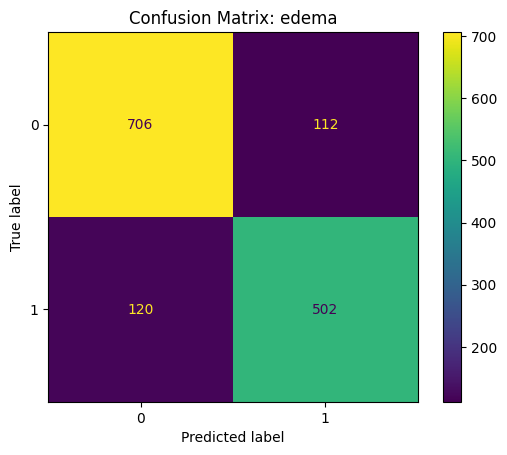

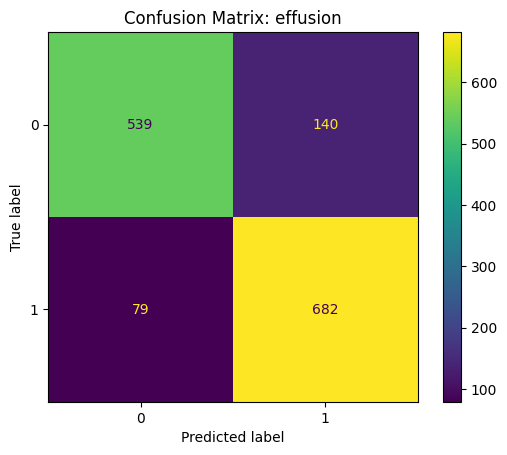

Metrics for dp0.1_wd0.01_lr1e-05_bs16: {'edema': {'precision': 0.8175895765472313, 'recall': 0.8070739549839229, 'f1': 0.8122977346278317, 'auroc': 0.9137709415954528, 'auprc': 0.8874056507521622, 'sensitivity': 0.8070739549839229, 'specificity': 0.863080684596577}, 'effusion': {'precision': 0.829683698296837, 'recall': 0.8961892247043364, 'f1': 0.8616550852811118, 'auroc': 0.9285278845949153, 'auprc': 0.9333265486902933, 'sensitivity': 0.8961892247043364, 'specificity': 0.7938144329896907}}
Running combination: dp0.1_wd0.01_lr1e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 1/20: train_loss=0.5361, val_loss=0.4780


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 2/20: train_loss=0.4195, val_loss=0.4358


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


Epoch 3/20: train_loss=0.3844, val_loss=0.4160


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


Epoch 4/20: train_loss=0.3596, val_loss=0.4168


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 5/20: train_loss=0.3457, val_loss=0.3973


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 6/20: train_loss=0.3291, val_loss=0.4219


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 7/20: train_loss=0.3150, val_loss=0.3716


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 8/20: train_loss=0.2976, val_loss=0.4038


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 9/20: train_loss=0.2924, val_loss=0.3715


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


Epoch 10/20: train_loss=0.2773, val_loss=0.3914


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 11/20: train_loss=0.2684, val_loss=0.4128


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 12/20: train_loss=0.2559, val_loss=0.3990


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 13/20: train_loss=0.2496, val_loss=0.3876


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 14/20: train_loss=0.2421, val_loss=0.3885
Early stopping at epoch 14


Evaluating: 100%|██████████| 45/45 [01:17<00:00,  1.72s/it]


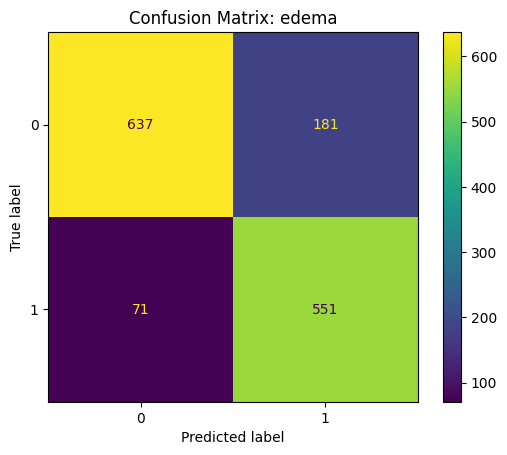

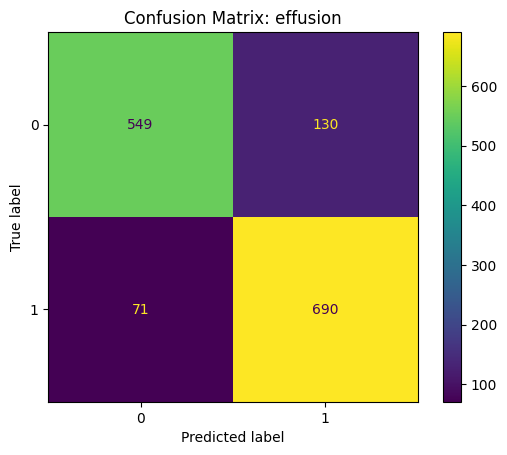

Metrics for dp0.1_wd0.01_lr1e-05_bs32: {'edema': {'precision': 0.7527322404371585, 'recall': 0.8858520900321544, 'f1': 0.8138847858197932, 'auroc': 0.9152115975754526, 'auprc': 0.8884907926471903, 'sensitivity': 0.8858520900321544, 'specificity': 0.7787286063569682}, 'effusion': {'precision': 0.8414634146341463, 'recall': 0.9067017082785808, 'f1': 0.872865275142315, 'auroc': 0.9296290633787416, 'auprc': 0.9293268815048569, 'sensitivity': 0.9067017082785808, 'specificity': 0.8085419734904271}}
Running combination: dp0.1_wd0.01_lr1e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Epoch 1/20: train_loss=0.5855, val_loss=0.5016


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 2/20: train_loss=0.4511, val_loss=0.4580


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 3/20: train_loss=0.4099, val_loss=0.4301


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 4/20: train_loss=0.3852, val_loss=0.4254


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.78s/it]


Epoch 5/20: train_loss=0.3711, val_loss=0.4132


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 6/20: train_loss=0.3468, val_loss=0.4365


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 7/20: train_loss=0.3337, val_loss=0.3921


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.71s/it]


Epoch 8/20: train_loss=0.3254, val_loss=0.4090


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 9/20: train_loss=0.3073, val_loss=0.4069


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.80s/it]


Epoch 10/20: train_loss=0.3071, val_loss=0.4040


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 11/20: train_loss=0.2968, val_loss=0.4145


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.75s/it]


Epoch 12/20: train_loss=0.2843, val_loss=0.4044
Early stopping at epoch 12


Evaluating: 100%|██████████| 23/23 [01:21<00:00,  3.55s/it]


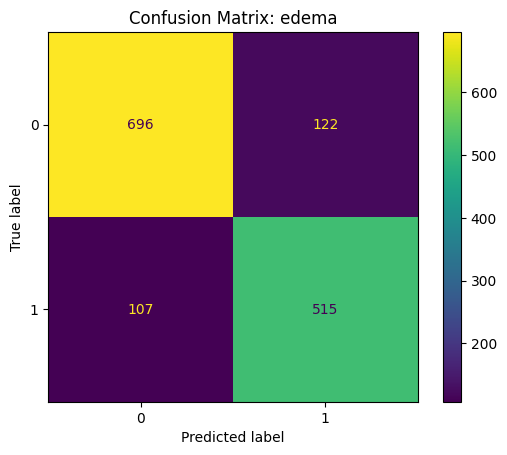

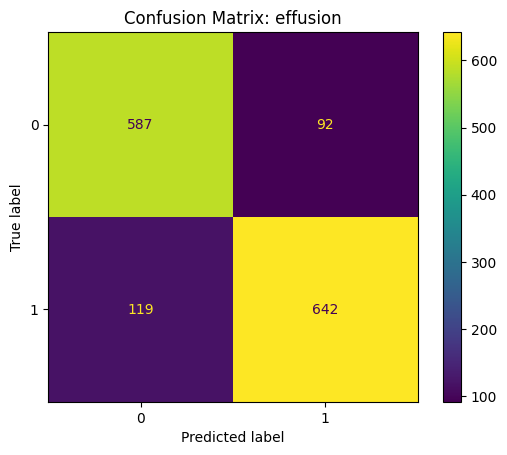

Metrics for dp0.1_wd0.01_lr1e-05_bs64: {'edema': {'precision': 0.8084772370486656, 'recall': 0.8279742765273312, 'f1': 0.818109610802224, 'auroc': 0.9134250269263123, 'auprc': 0.8911129132740896, 'sensitivity': 0.8279742765273312, 'specificity': 0.8508557457212714}, 'effusion': {'precision': 0.8746594005449592, 'recall': 0.8436268068331143, 'f1': 0.8588628762541806, 'auroc': 0.928823983635206, 'auprc': 0.9323325681858332, 'sensitivity': 0.8436268068331143, 'specificity': 0.8645066273932254}}


In [11]:
for i in range(9, 12):
    hyperparameters = hyperparameter_combinations[i]
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.1_wd0.01_lr5e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 1/20: train_loss=0.4570, val_loss=0.4091


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


Epoch 2/20: train_loss=0.3706, val_loss=0.3990


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 3/20: train_loss=0.3367, val_loss=0.3934


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 4/20: train_loss=0.3141, val_loss=0.3948


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 5/20: train_loss=0.2926, val_loss=0.4024


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]


Epoch 6/20: train_loss=0.2715, val_loss=0.4131


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 7/20: train_loss=0.2506, val_loss=0.4551


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 8/20: train_loss=0.2311, val_loss=0.3852


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 9/20: train_loss=0.2089, val_loss=0.3926


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 10/20: train_loss=0.1848, val_loss=0.4372


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 11/20: train_loss=0.1712, val_loss=0.4542


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


Epoch 12/20: train_loss=0.1452, val_loss=0.4894


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 13/20: train_loss=0.1243, val_loss=0.5326
Early stopping at epoch 13


Evaluating: 100%|██████████| 90/90 [01:25<00:00,  1.05it/s]


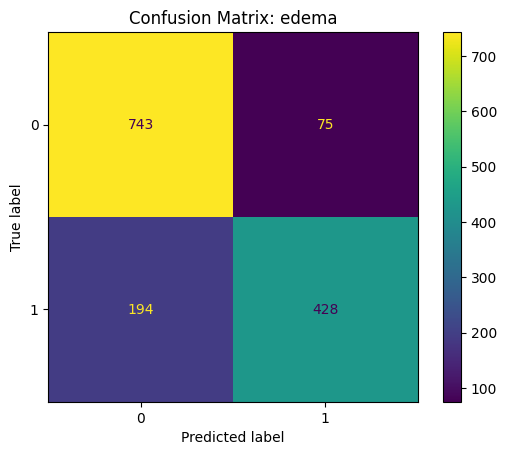

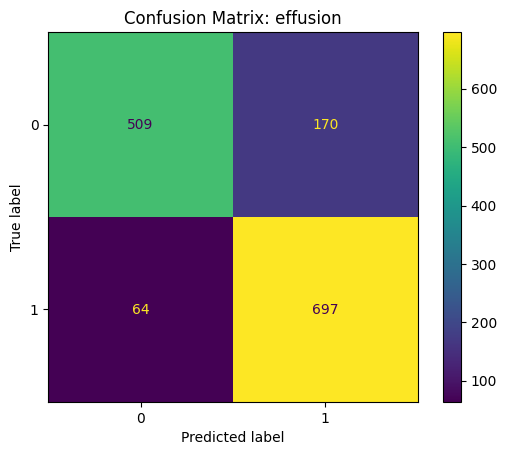

Metrics for dp0.1_wd0.01_lr5e-05_bs16: {'edema': {'precision': 0.8508946322067594, 'recall': 0.6881028938906752, 'f1': 0.7608888888888888, 'auroc': 0.902507095181566, 'auprc': 0.866143833638386, 'sensitivity': 0.6881028938906752, 'specificity': 0.9083129584352079}, 'effusion': {'precision': 0.803921568627451, 'recall': 0.9159001314060446, 'f1': 0.8562653562653563, 'auroc': 0.922389151550456, 'auprc': 0.9310743405270472, 'sensitivity': 0.9159001314060446, 'specificity': 0.7496318114874816}}
Running combination: dp0.1_wd0.01_lr5e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 1/20: train_loss=0.4715, val_loss=0.4257


Validation: 100%|██████████| 23/23 [00:44<00:00,  1.92s/it]


Epoch 2/20: train_loss=0.3828, val_loss=0.4057


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 3/20: train_loss=0.3427, val_loss=0.3938


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.87s/it]


Epoch 4/20: train_loss=0.3143, val_loss=0.4421


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 5/20: train_loss=0.3061, val_loss=0.3943


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.83s/it]


Epoch 6/20: train_loss=0.2812, val_loss=0.4022


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 7/20: train_loss=0.2629, val_loss=0.3931


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 8/20: train_loss=0.2390, val_loss=0.4074


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.82s/it]


Epoch 9/20: train_loss=0.2144, val_loss=0.4172


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.89s/it]


Epoch 10/20: train_loss=0.1972, val_loss=0.4300


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.87s/it]


Epoch 11/20: train_loss=0.1853, val_loss=0.4430


Validation: 100%|██████████| 23/23 [00:44<00:00,  1.94s/it]


Epoch 12/20: train_loss=0.1527, val_loss=0.4227
Early stopping at epoch 12


Evaluating: 100%|██████████| 45/45 [01:23<00:00,  1.87s/it]


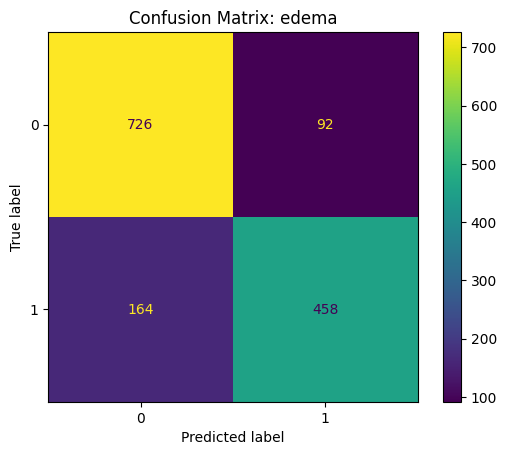

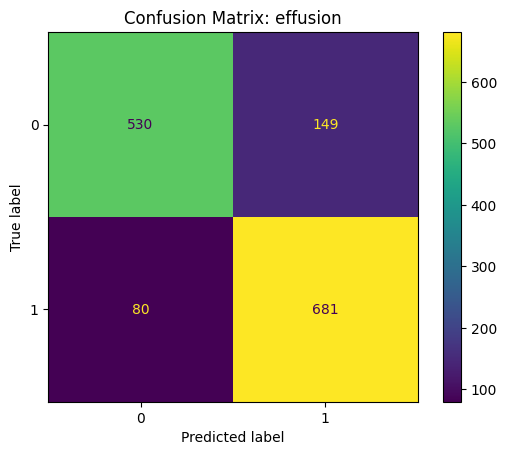

Metrics for dp0.1_wd0.01_lr5e-05_bs32: {'edema': {'precision': 0.8327272727272728, 'recall': 0.7363344051446945, 'f1': 0.7815699658703071, 'auroc': 0.9036647300686326, 'auprc': 0.8722729641617859, 'sensitivity': 0.7363344051446945, 'specificity': 0.8875305623471883}, 'effusion': {'precision': 0.8204819277108434, 'recall': 0.8948751642575559, 'f1': 0.8560653676932747, 'auroc': 0.9252378952583512, 'auprc': 0.931752162653981, 'sensitivity': 0.8948751642575559, 'specificity': 0.780559646539028}}
Running combination: dp0.1_wd0.01_lr5e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:46<00:00,  3.83s/it]


Epoch 1/20: train_loss=0.4852, val_loss=0.4319


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.82s/it]


Epoch 2/20: train_loss=0.3866, val_loss=0.4079


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


Epoch 3/20: train_loss=0.3487, val_loss=0.3884


Validation: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]


Epoch 4/20: train_loss=0.3197, val_loss=0.3884


Validation: 100%|██████████| 12/12 [01:08<00:00,  5.74s/it]


Epoch 5/20: train_loss=0.3103, val_loss=0.3870


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Epoch 6/20: train_loss=0.2971, val_loss=0.3948


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.80s/it]


Epoch 7/20: train_loss=0.2661, val_loss=0.4083


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.83s/it]


Epoch 8/20: train_loss=0.2594, val_loss=0.4173


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


Epoch 9/20: train_loss=0.2336, val_loss=0.4289


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Epoch 10/20: train_loss=0.2238, val_loss=0.4157
Early stopping at epoch 10


Evaluating: 100%|██████████| 23/23 [01:22<00:00,  3.60s/it]


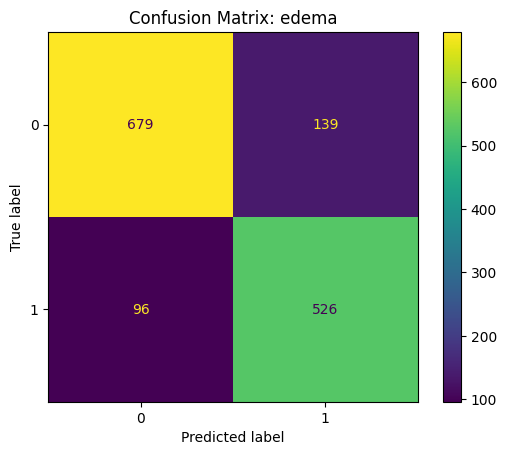

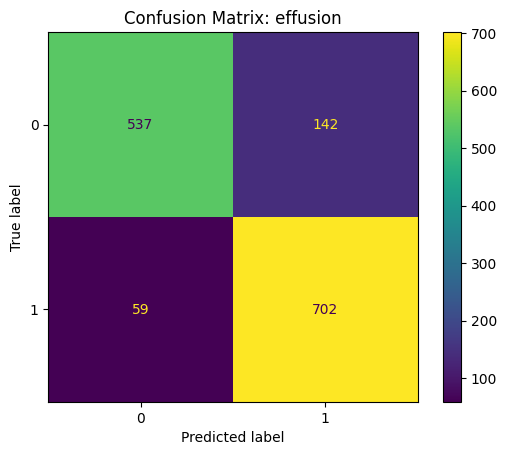

Metrics for dp0.1_wd0.01_lr5e-05_bs64: {'edema': {'precision': 0.7909774436090226, 'recall': 0.8456591639871383, 'f1': 0.8174048174048174, 'auroc': 0.9125897216173083, 'auprc': 0.8833736412705535, 'sensitivity': 0.8456591639871383, 'specificity': 0.8300733496332519}, 'effusion': {'precision': 0.8317535545023697, 'recall': 0.9224704336399474, 'f1': 0.874766355140187, 'auroc': 0.934074419558793, 'auprc': 0.9385732035461738, 'sensitivity': 0.9224704336399474, 'specificity': 0.7908689248895434}}


In [12]:
for i in range(12, 15):
    hyperparameters = hyperparameter_combinations[i]
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.1_wd0.01_lr0.0002_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 1/20: train_loss=0.6235, val_loss=0.6235


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 2/20: train_loss=0.5469, val_loss=0.5364


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.15it/s]


Epoch 3/20: train_loss=0.5072, val_loss=0.5310


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 4/20: train_loss=0.4737, val_loss=0.5433


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 5/20: train_loss=0.4652, val_loss=0.5059


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 6/20: train_loss=0.4538, val_loss=0.4865


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 7/20: train_loss=0.4303, val_loss=0.4793


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 8/20: train_loss=0.4269, val_loss=0.4465


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 9/20: train_loss=0.4222, val_loss=0.4451


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 10/20: train_loss=0.4125, val_loss=0.4593


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 11/20: train_loss=0.4055, val_loss=0.5115


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 12/20: train_loss=0.3993, val_loss=0.4590
Early stopping at epoch 12


Evaluating: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s]


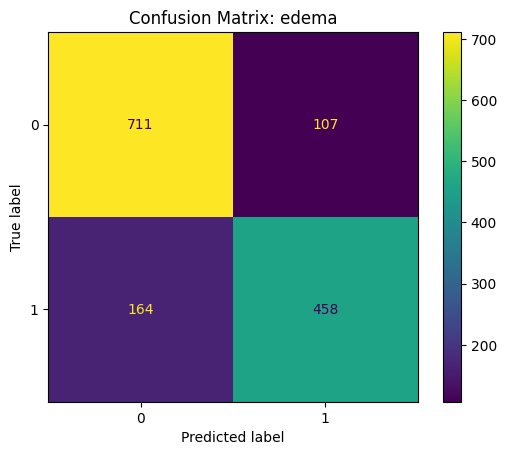

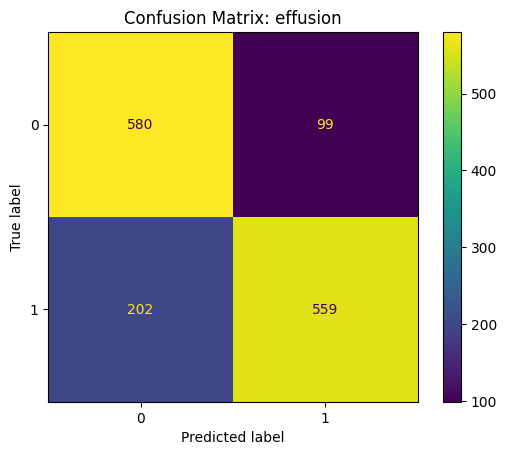

Metrics for dp0.1_wd0.01_lr0.0002_bs16: {'edema': {'precision': 0.8106194690265487, 'recall': 0.7363344051446945, 'f1': 0.7716933445661331, 'auroc': 0.8811350718166024, 'auprc': 0.8578157711219438, 'sensitivity': 0.7363344051446945, 'specificity': 0.8691931540342298}, 'effusion': {'precision': 0.8495440729483282, 'recall': 0.7345597897503285, 'f1': 0.7878787878787878, 'auroc': 0.8788354985978841, 'auprc': 0.892272735638818, 'sensitivity': 0.7345597897503285, 'specificity': 0.8541973490427098}}
Running combination: dp0.1_wd0.01_lr0.0002_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:41<00:00,  1.82s/it]


Epoch 1/20: train_loss=0.4816, val_loss=0.4797


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Epoch 2/20: train_loss=0.4142, val_loss=0.4386


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.82s/it]


Epoch 3/20: train_loss=0.3790, val_loss=0.4371


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 4/20: train_loss=0.3732, val_loss=0.4195


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.82s/it]


Epoch 5/20: train_loss=0.3625, val_loss=0.4693


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Epoch 6/20: train_loss=0.3499, val_loss=0.4263


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


Epoch 7/20: train_loss=0.3437, val_loss=0.4686
Early stopping at epoch 7


Evaluating: 100%|██████████| 45/45 [01:20<00:00,  1.78s/it]


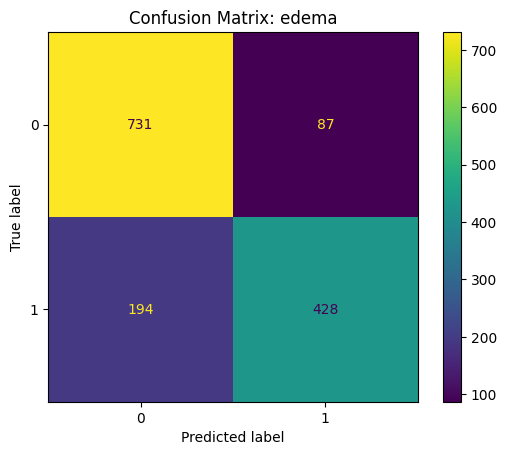

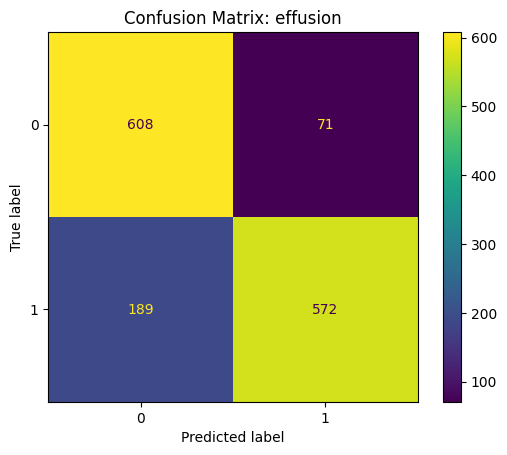

Metrics for dp0.1_wd0.01_lr0.0002_bs32: {'edema': {'precision': 0.8310679611650486, 'recall': 0.6881028938906752, 'f1': 0.752858399296394, 'auroc': 0.8908717835832043, 'auprc': 0.8601208773275815, 'sensitivity': 0.6881028938906752, 'specificity': 0.8936430317848411}, 'effusion': {'precision': 0.8895800933125972, 'recall': 0.7516425755584757, 'f1': 0.8148148148148148, 'auroc': 0.9206280396114715, 'auprc': 0.9279553648726175, 'sensitivity': 0.7516425755584757, 'specificity': 0.8954344624447718}}
Running combination: dp0.1_wd0.01_lr0.0002_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:50<00:00,  4.22s/it]


Epoch 1/20: train_loss=0.4834, val_loss=0.4663


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.13s/it]


Epoch 2/20: train_loss=0.3909, val_loss=0.4301


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.92s/it]


Epoch 3/20: train_loss=0.3634, val_loss=0.4227


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


Epoch 4/20: train_loss=0.3579, val_loss=0.4086


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.89s/it]


Epoch 5/20: train_loss=0.3324, val_loss=0.4034


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


Epoch 6/20: train_loss=0.3155, val_loss=0.4120


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


Epoch 7/20: train_loss=0.3006, val_loss=0.4146


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


Epoch 8/20: train_loss=0.2874, val_loss=0.3937


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


Epoch 9/20: train_loss=0.2683, val_loss=0.4299


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.96s/it]


Epoch 10/20: train_loss=0.2492, val_loss=0.4422


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.94s/it]


Epoch 11/20: train_loss=0.2409, val_loss=0.4141
Early stopping at epoch 11


Evaluating: 100%|██████████| 23/23 [01:31<00:00,  3.96s/it]


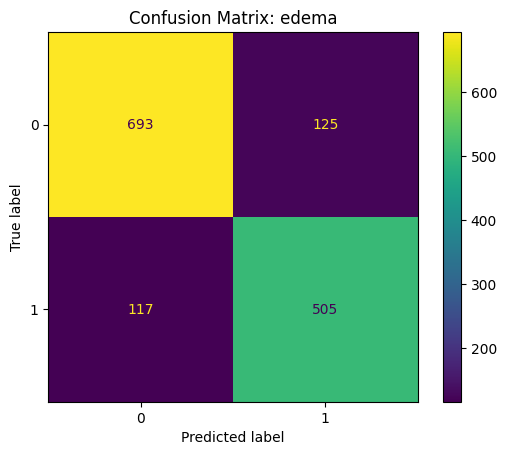

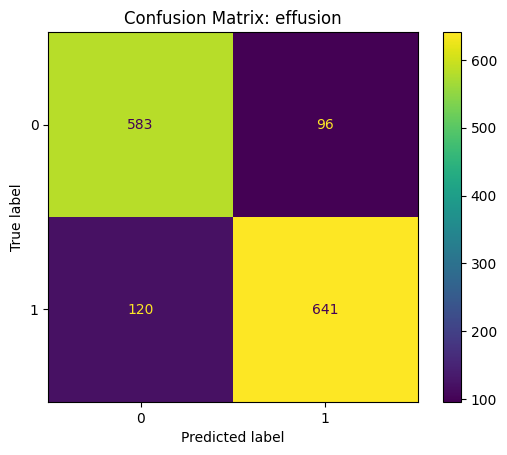

Metrics for dp0.1_wd0.01_lr0.0002_bs64: {'edema': {'precision': 0.8015873015873016, 'recall': 0.8118971061093248, 'f1': 0.8067092651757188, 'auroc': 0.9104022044198462, 'auprc': 0.8826429050343529, 'sensitivity': 0.8118971061093248, 'specificity': 0.8471882640586798}, 'effusion': {'precision': 0.8697421981004071, 'recall': 0.8423127463863338, 'f1': 0.855807743658211, 'auroc': 0.9244792624230965, 'auprc': 0.931846154401874, 'sensitivity': 0.8423127463863338, 'specificity': 0.8586156111929307}}


In [8]:
for i in range(15, 18):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)

In [9]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.1_wd0.1_lr1e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:38<00:00,  1.17it/s]


Epoch 1/20: train_loss=0.5161, val_loss=0.4511


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.15it/s]


Epoch 2/20: train_loss=0.4150, val_loss=0.4322


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 3/20: train_loss=0.3751, val_loss=0.4409


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 4/20: train_loss=0.3524, val_loss=0.4131


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 5/20: train_loss=0.3322, val_loss=0.3981


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 6/20: train_loss=0.3183, val_loss=0.3848


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 7/20: train_loss=0.3010, val_loss=0.4145


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 8/20: train_loss=0.2843, val_loss=0.3969


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 9/20: train_loss=0.2735, val_loss=0.4095
Early stopping at epoch 9


Evaluating: 100%|██████████| 90/90 [01:14<00:00,  1.21it/s]


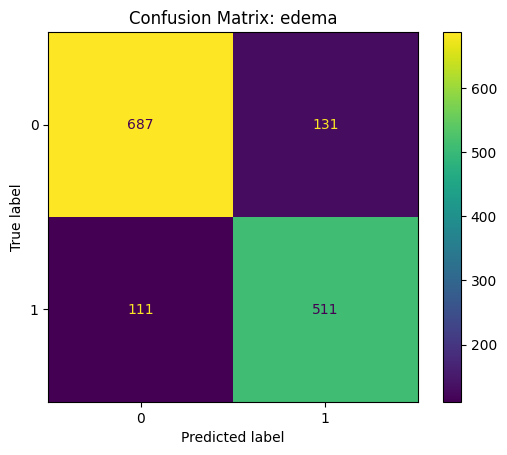

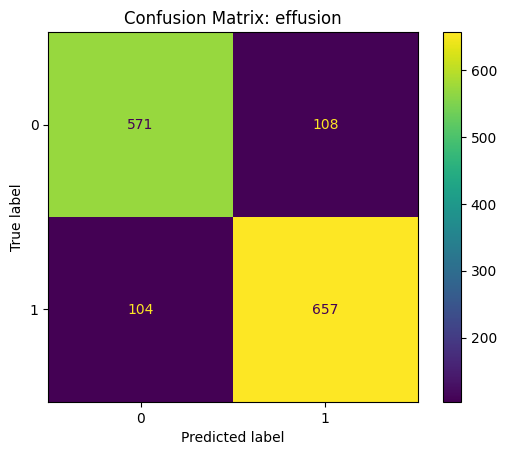

Metrics for dp0.1_wd0.1_lr1e-05_bs16: {'edema': {'precision': 0.7959501557632399, 'recall': 0.8215434083601286, 'f1': 0.8085443037974683, 'auroc': 0.9103727230559988, 'auprc': 0.8876418609646426, 'sensitivity': 0.8215434083601286, 'specificity': 0.8398533007334963}, 'effusion': {'precision': 0.8588235294117647, 'recall': 0.8633377135348226, 'f1': 0.8610747051114024, 'auroc': 0.9309876354459581, 'auprc': 0.9345789992459103, 'sensitivity': 0.8633377135348226, 'specificity': 0.8409425625920471}}
Running combination: dp0.1_wd0.1_lr1e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 1/20: train_loss=0.5443, val_loss=0.4837


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 2/20: train_loss=0.4295, val_loss=0.4384


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 3/20: train_loss=0.3889, val_loss=0.4310


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 4/20: train_loss=0.3668, val_loss=0.4158


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 5/20: train_loss=0.3476, val_loss=0.4028


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 6/20: train_loss=0.3301, val_loss=0.4165


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 7/20: train_loss=0.3225, val_loss=0.4013


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 8/20: train_loss=0.3098, val_loss=0.4150


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 9/20: train_loss=0.2938, val_loss=0.3963


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 10/20: train_loss=0.2767, val_loss=0.4011


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 11/20: train_loss=0.2687, val_loss=0.3928


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 12/20: train_loss=0.2509, val_loss=0.4046


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 13/20: train_loss=0.2439, val_loss=0.4146


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 14/20: train_loss=0.2341, val_loss=0.4074
Early stopping at epoch 14


Evaluating: 100%|██████████| 45/45 [01:16<00:00,  1.71s/it]


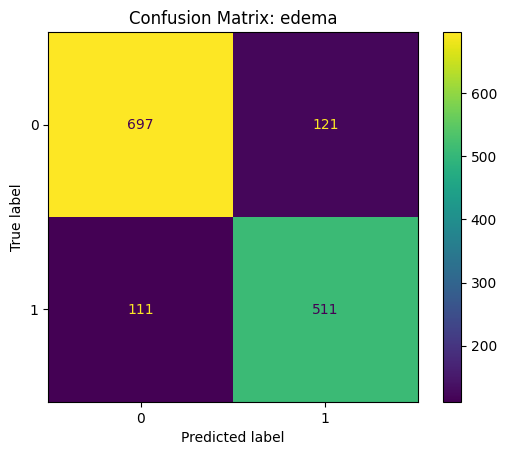

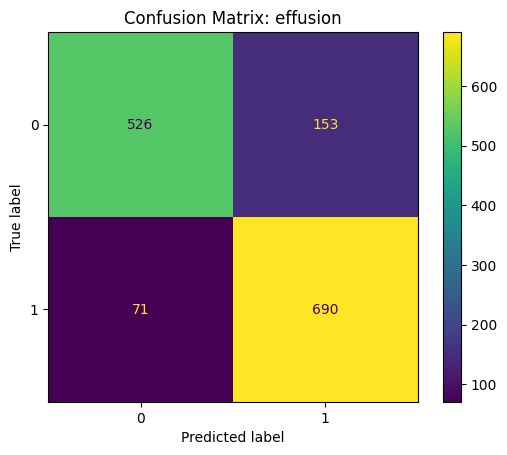

Metrics for dp0.1_wd0.1_lr1e-05_bs32: {'edema': {'precision': 0.8085443037974683, 'recall': 0.8215434083601286, 'f1': 0.8149920255183413, 'auroc': 0.910504406481183, 'auprc': 0.8819871362625806, 'sensitivity': 0.8215434083601286, 'specificity': 0.8520782396088019}, 'effusion': {'precision': 0.8185053380782918, 'recall': 0.9067017082785808, 'f1': 0.8603491271820449, 'auroc': 0.925384977134574, 'auprc': 0.9273534167543711, 'sensitivity': 0.9067017082785808, 'specificity': 0.7746686303387335}}
Running combination: dp0.1_wd0.1_lr1e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


Epoch 1/20: train_loss=0.5902, val_loss=0.4997


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 2/20: train_loss=0.4429, val_loss=0.4540


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.75s/it]


Epoch 3/20: train_loss=0.4029, val_loss=0.4363


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 4/20: train_loss=0.3782, val_loss=0.4152


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.78s/it]


Epoch 5/20: train_loss=0.3614, val_loss=0.4019


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it]


Epoch 6/20: train_loss=0.3469, val_loss=0.3975


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 7/20: train_loss=0.3371, val_loss=0.4010


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 8/20: train_loss=0.3249, val_loss=0.4033


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.75s/it]


Epoch 9/20: train_loss=0.3138, val_loss=0.3865


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Epoch 10/20: train_loss=0.2998, val_loss=0.3868


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Epoch 11/20: train_loss=0.2893, val_loss=0.3901


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.71s/it]


Epoch 12/20: train_loss=0.2845, val_loss=0.3924
Early stopping at epoch 12


Evaluating: 100%|██████████| 23/23 [01:22<00:00,  3.57s/it]


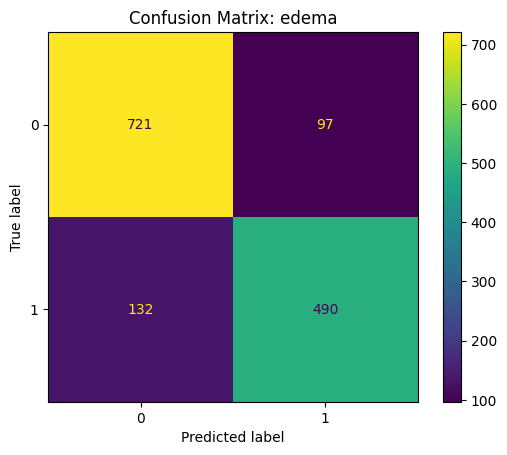

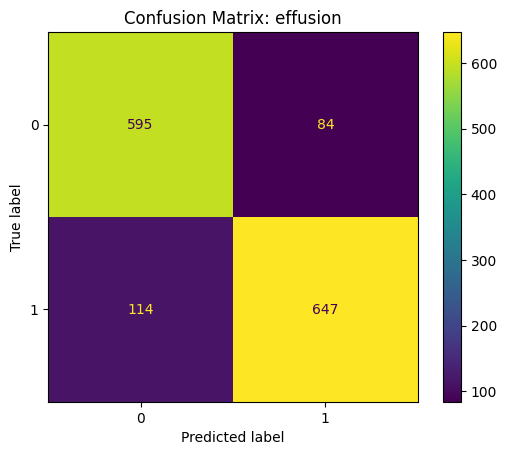

Metrics for dp0.1_wd0.1_lr1e-05_bs64: {'edema': {'precision': 0.8347529812606473, 'recall': 0.7877813504823151, 'f1': 0.8105872622001654, 'auroc': 0.9120610224923154, 'auprc': 0.893781038757822, 'sensitivity': 0.7877813504823151, 'specificity': 0.8814180929095354}, 'effusion': {'precision': 0.8850889192886456, 'recall': 0.8501971090670171, 'f1': 0.8672922252010724, 'auroc': 0.9339621728637808, 'auprc': 0.9339026063056042, 'sensitivity': 0.8501971090670171, 'specificity': 0.8762886597938144}}


In [10]:
for i in range(18, 21):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)

In [11]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.1_wd0.1_lr5e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 1/20: train_loss=0.4594, val_loss=0.4187


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 2/20: train_loss=0.3671, val_loss=0.3849


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 3/20: train_loss=0.3505, val_loss=0.3996


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 4/20: train_loss=0.3216, val_loss=0.3774


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 5/20: train_loss=0.2982, val_loss=0.3865


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 6/20: train_loss=0.2858, val_loss=0.3993


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 7/20: train_loss=0.2598, val_loss=0.4168
Early stopping at epoch 7


Evaluating: 100%|██████████| 90/90 [01:15<00:00,  1.20it/s]


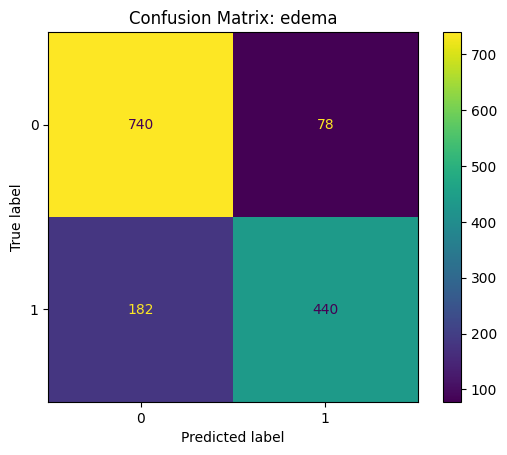

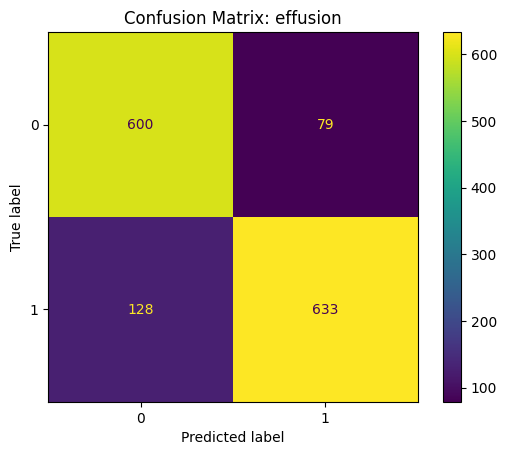

Metrics for dp0.1_wd0.1_lr5e-05_bs16: {'edema': {'precision': 0.8494208494208494, 'recall': 0.707395498392283, 'f1': 0.7719298245614035, 'auroc': 0.906036997146204, 'auprc': 0.8806650688225107, 'sensitivity': 0.707395498392283, 'specificity': 0.9046454767726161}, 'effusion': {'precision': 0.8890449438202247, 'recall': 0.8318002628120894, 'f1': 0.8594704684317719, 'auroc': 0.9376005140124516, 'auprc': 0.9452013883514747, 'sensitivity': 0.8318002628120894, 'specificity': 0.8836524300441826}}
Running combination: dp0.1_wd0.1_lr5e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 1/20: train_loss=0.4715, val_loss=0.4175


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 2/20: train_loss=0.3702, val_loss=0.4097


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 3/20: train_loss=0.3359, val_loss=0.4038


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 4/20: train_loss=0.3186, val_loss=0.3949


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 5/20: train_loss=0.2997, val_loss=0.4087


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 6/20: train_loss=0.2786, val_loss=0.3913


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 7/20: train_loss=0.2638, val_loss=0.3784


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


Epoch 8/20: train_loss=0.2442, val_loss=0.4158


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


Epoch 9/20: train_loss=0.2287, val_loss=0.4090


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 10/20: train_loss=0.2006, val_loss=0.3926
Early stopping at epoch 10


Evaluating: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


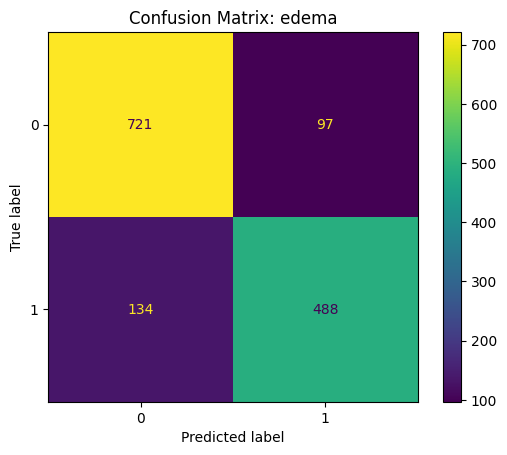

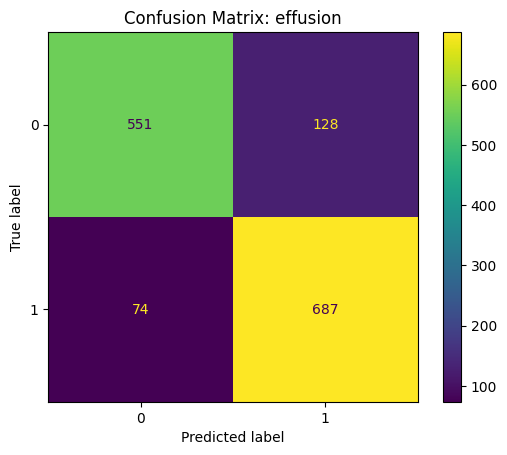

Metrics for dp0.1_wd0.1_lr5e-05_bs32: {'edema': {'precision': 0.8341880341880342, 'recall': 0.7845659163987139, 'f1': 0.8086164043082021, 'auroc': 0.9150504327864213, 'auprc': 0.8898193600487292, 'sensitivity': 0.7845659163987139, 'specificity': 0.8814180929095354}, 'effusion': {'precision': 0.8429447852760736, 'recall': 0.9027595269382391, 'f1': 0.8718274111675127, 'auroc': 0.9347556408802463, 'auprc': 0.9400207048740385, 'sensitivity': 0.9027595269382391, 'specificity': 0.8114874815905744}}
Running combination: dp0.1_wd0.1_lr5e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:45<00:00,  3.80s/it]


Epoch 1/20: train_loss=0.4898, val_loss=0.4559


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.75s/it]


Epoch 2/20: train_loss=0.3842, val_loss=0.4568


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it]


Epoch 3/20: train_loss=0.3519, val_loss=0.4214


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it]


Epoch 4/20: train_loss=0.3344, val_loss=0.4403


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.70s/it]


Epoch 5/20: train_loss=0.3057, val_loss=0.4111


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 6/20: train_loss=0.2899, val_loss=0.4062


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


Epoch 7/20: train_loss=0.2707, val_loss=0.3839


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 8/20: train_loss=0.2500, val_loss=0.3860


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 9/20: train_loss=0.2312, val_loss=0.4224


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it]


Epoch 10/20: train_loss=0.2175, val_loss=0.4113
Early stopping at epoch 10


Evaluating: 100%|██████████| 23/23 [01:21<00:00,  3.56s/it]


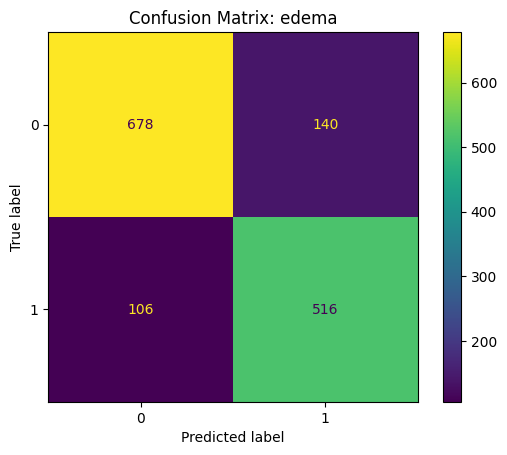

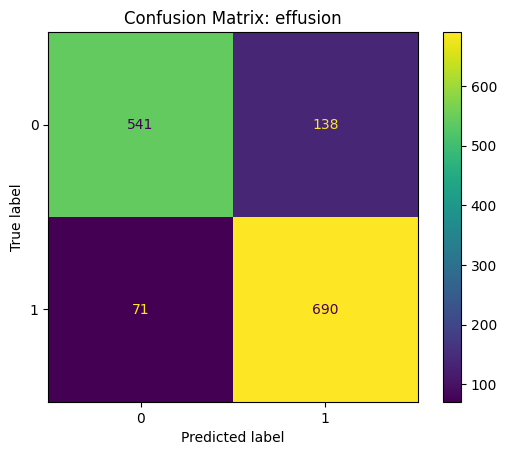

Metrics for dp0.1_wd0.1_lr5e-05_bs64: {'edema': {'precision': 0.7865853658536586, 'recall': 0.8295819935691319, 'f1': 0.8075117370892019, 'auroc': 0.9118192753087683, 'auprc': 0.8875618967591137, 'sensitivity': 0.8295819935691319, 'specificity': 0.8288508557457213}, 'effusion': {'precision': 0.8333333333333334, 'recall': 0.9067017082785808, 'f1': 0.868470736312146, 'auroc': 0.9304709135913329, 'auprc': 0.9313089212220249, 'sensitivity': 0.9067017082785808, 'specificity': 0.7967599410898379}}


In [12]:
for i in range(21, 24):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.1_wd0.1_lr0.0002_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 1/20: train_loss=0.6005, val_loss=0.5510


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 2/20: train_loss=0.5146, val_loss=0.5075


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 3/20: train_loss=0.4746, val_loss=0.4846


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 4/20: train_loss=0.4449, val_loss=0.4848


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 5/20: train_loss=0.4374, val_loss=0.4933


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 6/20: train_loss=0.4283, val_loss=0.4484


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 7/20: train_loss=0.4130, val_loss=0.4473


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 8/20: train_loss=0.4031, val_loss=0.4632


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 9/20: train_loss=0.4093, val_loss=0.4221


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 10/20: train_loss=0.3872, val_loss=0.4474


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 11/20: train_loss=0.3864, val_loss=0.4427


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 12/20: train_loss=0.3725, val_loss=0.4583
Early stopping at epoch 12


Evaluating: 100%|██████████| 90/90 [01:19<00:00,  1.13it/s]


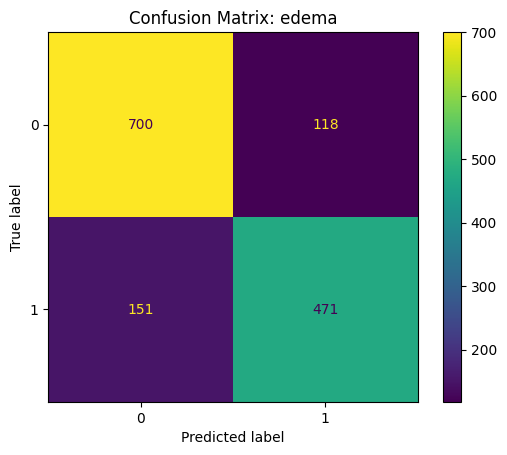

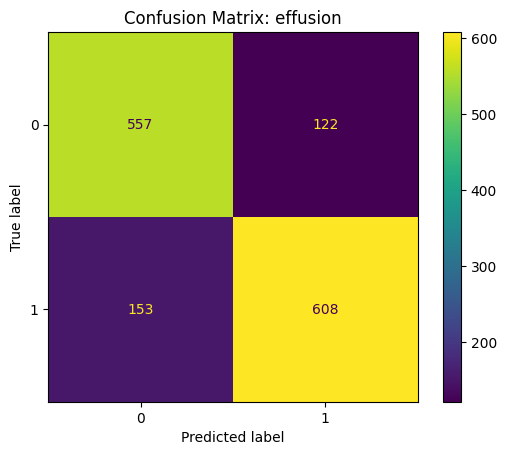

Metrics for dp0.1_wd0.1_lr0.0002_bs16: {'edema': {'precision': 0.799660441426146, 'recall': 0.7572347266881029, 'f1': 0.7778695293146161, 'auroc': 0.8829825706176935, 'auprc': 0.8588058324050644, 'sensitivity': 0.7572347266881029, 'specificity': 0.8557457212713936}, 'effusion': {'precision': 0.8328767123287671, 'recall': 0.7989487516425755, 'f1': 0.8155600268276325, 'auroc': 0.894524877157604, 'auprc': 0.9071109819078227, 'sensitivity': 0.7989487516425755, 'specificity': 0.8203240058910162}}
Running combination: dp0.1_wd0.1_lr0.0002_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:41<00:00,  1.82s/it]


Epoch 1/20: train_loss=0.4873, val_loss=0.4831


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.91s/it]


Epoch 2/20: train_loss=0.4125, val_loss=0.4564


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.89s/it]


Epoch 3/20: train_loss=0.3840, val_loss=0.4433


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 4/20: train_loss=0.3750, val_loss=0.4180


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 5/20: train_loss=0.3472, val_loss=0.4385


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 6/20: train_loss=0.3548, val_loss=0.4177


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.82s/it]


Epoch 7/20: train_loss=0.3485, val_loss=0.4538


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 8/20: train_loss=0.3265, val_loss=0.4042


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 9/20: train_loss=0.3117, val_loss=0.3990


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.87s/it]


Epoch 10/20: train_loss=0.3108, val_loss=0.4044


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Epoch 11/20: train_loss=0.3017, val_loss=0.4042


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


Epoch 12/20: train_loss=0.2861, val_loss=0.4409
Early stopping at epoch 12


Evaluating: 100%|██████████| 45/45 [01:18<00:00,  1.75s/it]


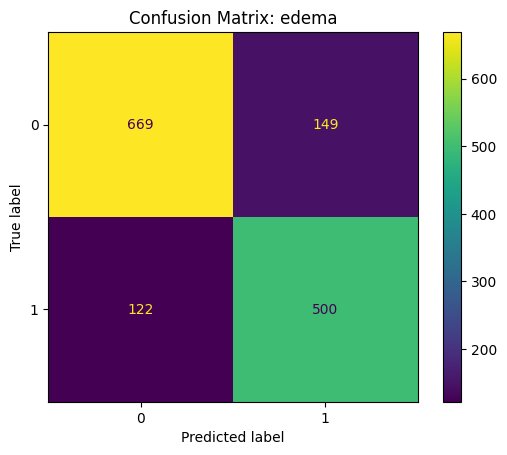

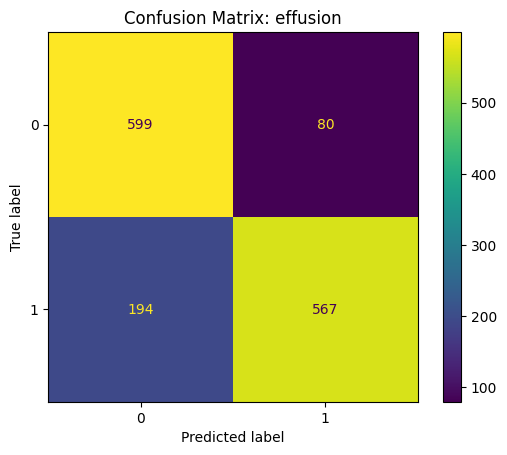

Metrics for dp0.1_wd0.1_lr0.0002_bs32: {'edema': {'precision': 0.7704160246533128, 'recall': 0.8038585209003215, 'f1': 0.7867820613690008, 'auroc': 0.8939280183020307, 'auprc': 0.8577467952448803, 'sensitivity': 0.8038585209003215, 'specificity': 0.8178484107579462}, 'effusion': {'precision': 0.8763523956723338, 'recall': 0.7450722733245729, 'f1': 0.8053977272727273, 'auroc': 0.9126720712805219, 'auprc': 0.9188781308329648, 'sensitivity': 0.7450722733245729, 'specificity': 0.882179675994109}}
Running combination: dp0.1_wd0.1_lr0.0002_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it]


Epoch 1/20: train_loss=0.4882, val_loss=0.5327


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.08s/it]


Epoch 2/20: train_loss=0.4228, val_loss=0.4462


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 3/20: train_loss=0.3761, val_loss=0.4192


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


Epoch 4/20: train_loss=0.3473, val_loss=0.4045


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.08s/it]


Epoch 5/20: train_loss=0.3353, val_loss=0.4292


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.01s/it]


Epoch 6/20: train_loss=0.3211, val_loss=0.4129


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.92s/it]


Epoch 7/20: train_loss=0.3040, val_loss=0.4095
Early stopping at epoch 7


Evaluating: 100%|██████████| 23/23 [01:27<00:00,  3.80s/it]


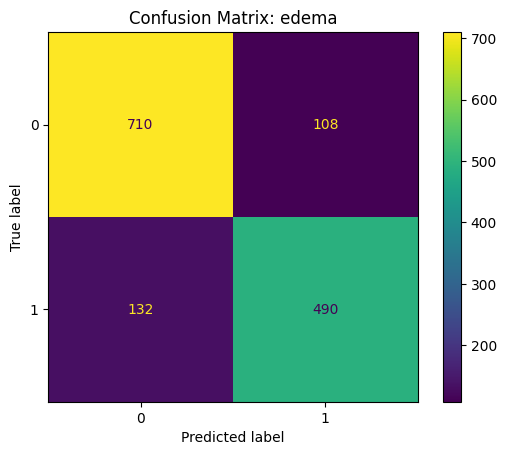

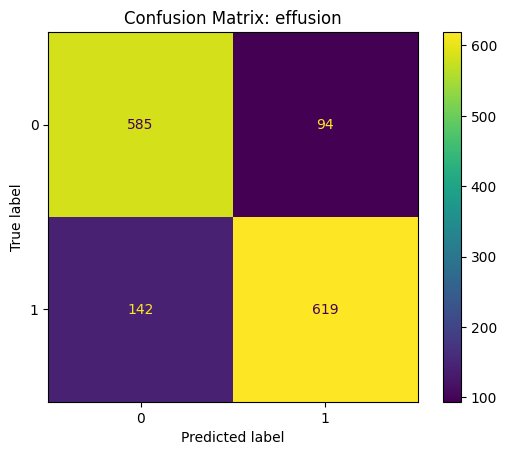

Metrics for dp0.1_wd0.1_lr0.0002_bs64: {'edema': {'precision': 0.8193979933110368, 'recall': 0.7877813504823151, 'f1': 0.8032786885245902, 'auroc': 0.9080240410695053, 'auprc': 0.8784442252348293, 'sensitivity': 0.7877813504823151, 'specificity': 0.8679706601466992}, 'effusion': {'precision': 0.8681626928471248, 'recall': 0.8134034165571616, 'f1': 0.8398914518317503, 'auroc': 0.9258649285201435, 'auprc': 0.924804449628521, 'sensitivity': 0.8134034165571616, 'specificity': 0.8615611192930781}}


In [8]:
for i in range(24, 27):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)

In [9]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.1_wd0.1_lr0.0002_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 1/20: train_loss=0.5471, val_loss=0.5085


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 2/20: train_loss=0.4652, val_loss=0.4735


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 3/20: train_loss=0.4292, val_loss=0.4431


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 4/20: train_loss=0.4158, val_loss=0.4844


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 5/20: train_loss=0.4053, val_loss=0.4289


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 6/20: train_loss=0.3964, val_loss=0.4556


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 7/20: train_loss=0.3832, val_loss=0.4596


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 8/20: train_loss=0.3775, val_loss=0.4520
Early stopping at epoch 8


Evaluating: 100%|██████████| 90/90 [01:15<00:00,  1.19it/s]


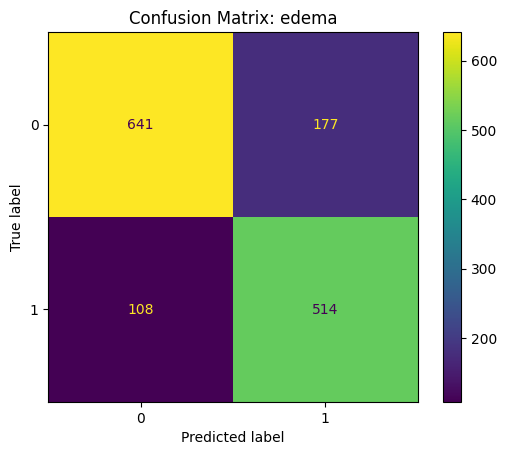

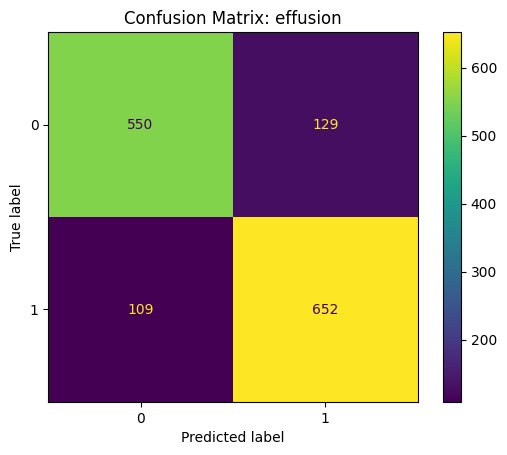

Metrics for dp0.1_wd0.1_lr0.0002_bs16: {'edema': {'precision': 0.743849493487699, 'recall': 0.8263665594855305, 'f1': 0.7829398324447829, 'auroc': 0.8955573550106526, 'auprc': 0.8572774635313226, 'sensitivity': 0.8263665594855305, 'specificity': 0.7836185819070904}, 'effusion': {'precision': 0.8348271446862996, 'recall': 0.8567674113009198, 'f1': 0.8456549935149157, 'auroc': 0.9047625498578531, 'auprc': 0.9024343429733221, 'sensitivity': 0.8567674113009198, 'specificity': 0.8100147275405007}}
Running combination: dp0.1_wd0.1_lr0.0002_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:43<00:00,  1.89s/it]


Epoch 1/20: train_loss=0.5000, val_loss=0.5700


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.87s/it]


Epoch 2/20: train_loss=0.4179, val_loss=0.4255


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.90s/it]


Epoch 3/20: train_loss=0.3917, val_loss=0.4145


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 4/20: train_loss=0.3670, val_loss=0.4202


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 5/20: train_loss=0.3548, val_loss=0.4067


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 6/20: train_loss=0.3594, val_loss=0.4321


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.87s/it]


Epoch 7/20: train_loss=0.3460, val_loss=0.4187


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.88s/it]


Epoch 8/20: train_loss=0.3288, val_loss=0.4176
Early stopping at epoch 8


Evaluating: 100%|██████████| 45/45 [01:21<00:00,  1.80s/it]


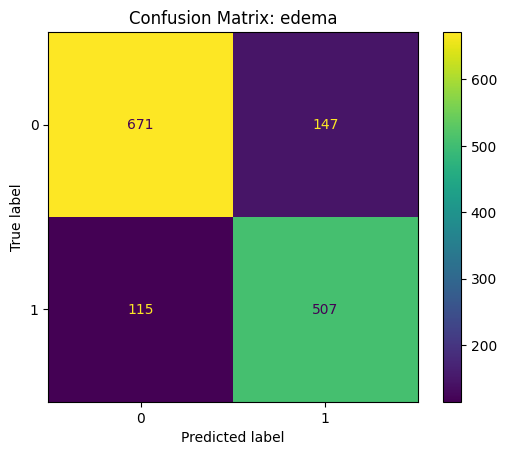

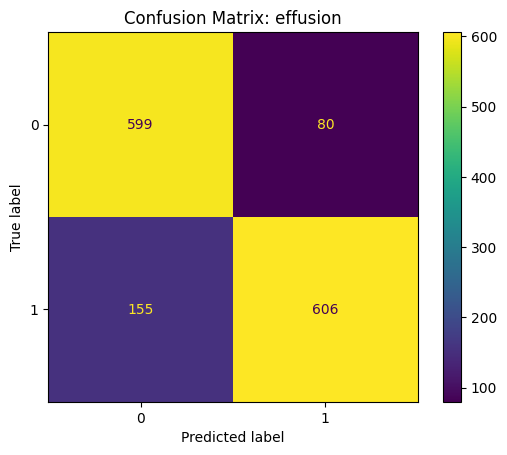

Metrics for dp0.1_wd0.1_lr0.0002_bs32: {'edema': {'precision': 0.7752293577981652, 'recall': 0.815112540192926, 'f1': 0.7946708463949843, 'auroc': 0.9023400341197652, 'auprc': 0.8754937814354491, 'sensitivity': 0.815112540192926, 'specificity': 0.8202933985330073}, 'effusion': {'precision': 0.8833819241982507, 'recall': 0.7963206307490145, 'f1': 0.8375950241879752, 'auroc': 0.9237090178607715, 'auprc': 0.9317495123834454, 'sensitivity': 0.7963206307490145, 'specificity': 0.882179675994109}}
Running combination: dp0.1_wd0.1_lr0.0002_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:45<00:00,  3.82s/it]


Epoch 1/20: train_loss=0.4990, val_loss=0.6037


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Epoch 2/20: train_loss=0.4120, val_loss=0.4418


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 3/20: train_loss=0.3592, val_loss=0.4065


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 4/20: train_loss=0.3525, val_loss=0.4040


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.81s/it]


Epoch 5/20: train_loss=0.3430, val_loss=0.4093


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


Epoch 6/20: train_loss=0.3214, val_loss=0.4048


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.78s/it]


Epoch 7/20: train_loss=0.3091, val_loss=0.4079
Early stopping at epoch 7


Evaluating: 100%|██████████| 23/23 [01:22<00:00,  3.59s/it]


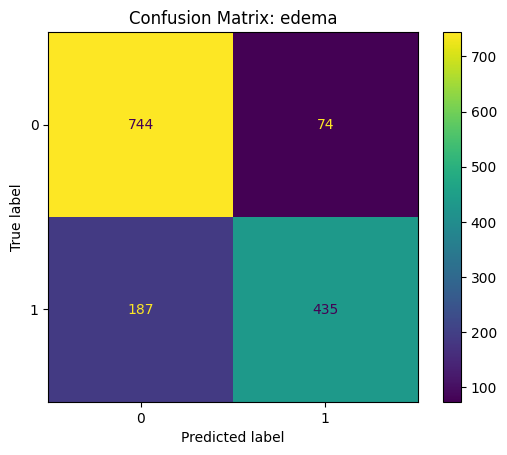

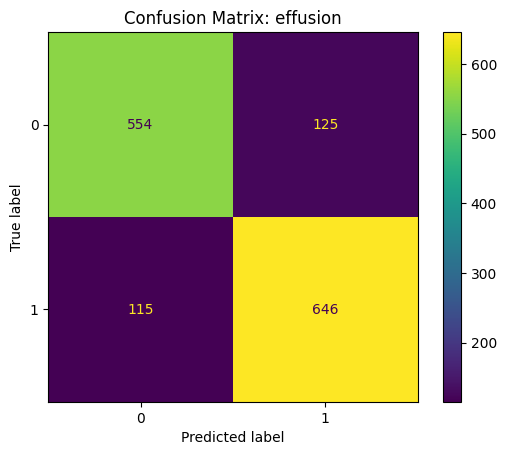

Metrics for dp0.1_wd0.1_lr0.0002_bs64: {'edema': {'precision': 0.8546168958742633, 'recall': 0.6993569131832797, 'f1': 0.7692307692307693, 'auroc': 0.9031262038223571, 'auprc': 0.8709988077087572, 'sensitivity': 0.6993569131832797, 'specificity': 0.9095354523227384}, 'effusion': {'precision': 0.8378728923476005, 'recall': 0.8488830486202366, 'f1': 0.8433420365535248, 'auroc': 0.9150040931337922, 'auprc': 0.9243137949143332, 'sensitivity': 0.8488830486202366, 'specificity': 0.8159057437407953}}


In [ ]:
for i in range(24, 27):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)

In [11]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.2_wd0_lr1e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:44<00:00,  1.00it/s]


Epoch 1/20: train_loss=0.5115, val_loss=0.4573


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]


Epoch 2/20: train_loss=0.4121, val_loss=0.4295


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 3/20: train_loss=0.3723, val_loss=0.4080


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 4/20: train_loss=0.3469, val_loss=0.3950


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 5/20: train_loss=0.3294, val_loss=0.3899


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 6/20: train_loss=0.3146, val_loss=0.3827


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 7/20: train_loss=0.2974, val_loss=0.3765


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 8/20: train_loss=0.2887, val_loss=0.4082


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 9/20: train_loss=0.2737, val_loss=0.3791


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 10/20: train_loss=0.2549, val_loss=0.3821
Early stopping at epoch 10


Evaluating: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


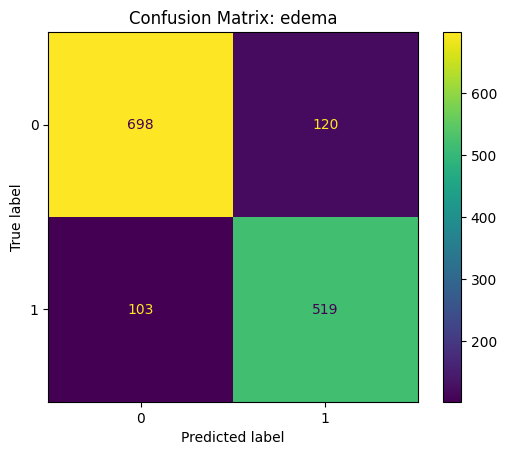

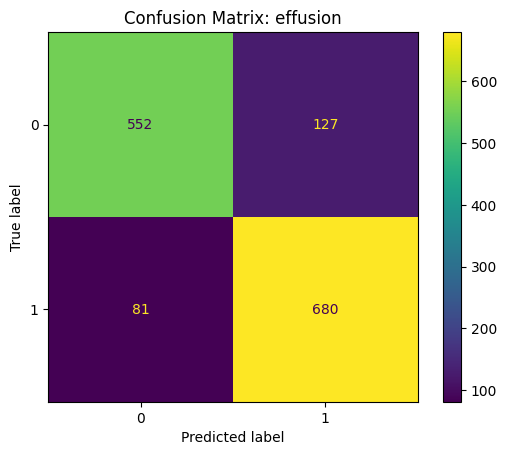

Metrics for dp0.2_wd0_lr1e-05_bs16: {'edema': {'precision': 0.812206572769953, 'recall': 0.8344051446945338, 'f1': 0.8231562252180809, 'auroc': 0.9196652489406363, 'auprc': 0.8924613586062011, 'sensitivity': 0.8344051446945338, 'specificity': 0.8533007334963325}, 'effusion': {'precision': 0.8426270136307311, 'recall': 0.8935611038107752, 'f1': 0.8673469387755102, 'auroc': 0.9346550059123044, 'auprc': 0.937432907834126, 'sensitivity': 0.8935611038107752, 'specificity': 0.812960235640648}}
Running combination: dp0.2_wd0_lr1e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


Epoch 1/20: train_loss=0.5420, val_loss=0.4796


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.82s/it]


Epoch 2/20: train_loss=0.4240, val_loss=0.4670


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


Epoch 3/20: train_loss=0.3983, val_loss=0.4247


Validation: 100%|██████████| 23/23 [00:44<00:00,  1.92s/it]


Epoch 4/20: train_loss=0.3701, val_loss=0.4094


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 5/20: train_loss=0.3517, val_loss=0.4019


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Epoch 6/20: train_loss=0.3313, val_loss=0.3906


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


Epoch 7/20: train_loss=0.3182, val_loss=0.3964


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Epoch 8/20: train_loss=0.3120, val_loss=0.4058


Validation: 100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Epoch 9/20: train_loss=0.2965, val_loss=0.3978
Early stopping at epoch 9


Evaluating: 100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


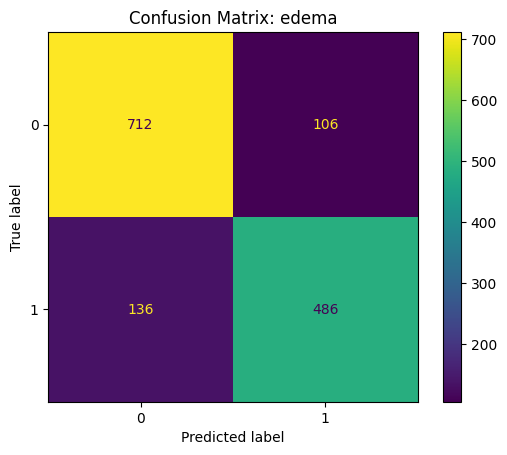

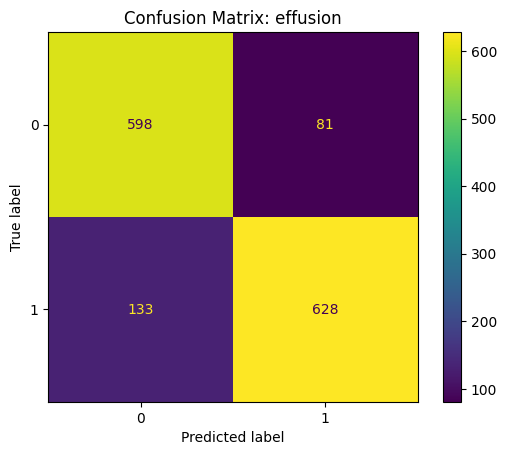

Metrics for dp0.2_wd0_lr1e-05_bs32: {'edema': {'precision': 0.8209459459459459, 'recall': 0.7813504823151125, 'f1': 0.800658978583196, 'auroc': 0.9141718881437748, 'auprc': 0.8920180932169155, 'sensitivity': 0.7813504823151125, 'specificity': 0.8704156479217604}, 'effusion': {'precision': 0.8857545839210155, 'recall': 0.8252299605781866, 'f1': 0.854421768707483, 'auroc': 0.9336912325654756, 'auprc': 0.9363158316344704, 'sensitivity': 0.8252299605781866, 'specificity': 0.8807069219440353}}


In [9]:
for i in range(27, 30):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    if hyperparameters['batch_size'] == 64:
        continue
    execute_hyperparameter_combinations(hyperparameters)

In [10]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.2_wd0_lr5e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s]


Epoch 1/20: train_loss=0.4697, val_loss=0.4376


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 2/20: train_loss=0.3769, val_loss=0.4171


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 3/20: train_loss=0.3431, val_loss=0.4147


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 4/20: train_loss=0.3248, val_loss=0.3821


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.15it/s]


Epoch 5/20: train_loss=0.3030, val_loss=0.3873


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 6/20: train_loss=0.2865, val_loss=0.4310


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 7/20: train_loss=0.2685, val_loss=0.3940
Early stopping at epoch 7


Evaluating: 100%|██████████| 90/90 [01:18<00:00,  1.15it/s]


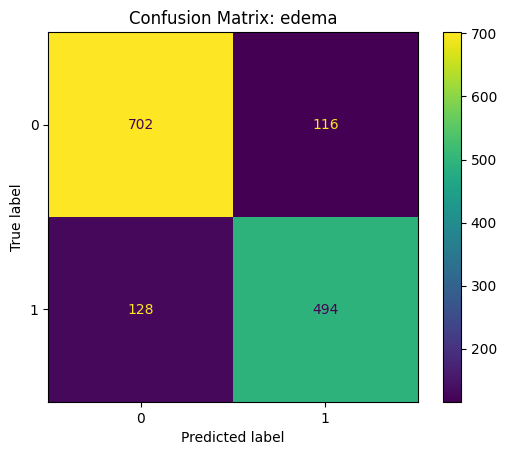

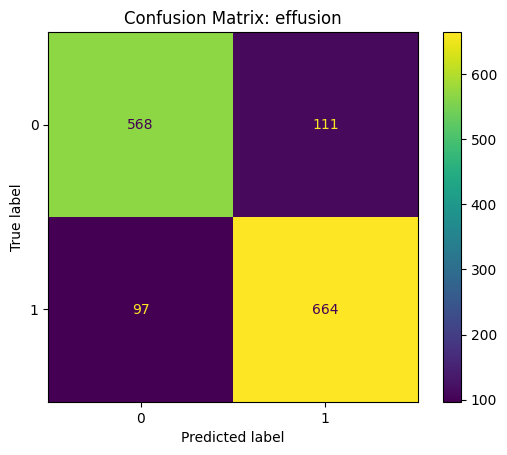

Metrics for dp0.2_wd0_lr5e-05_bs16: {'edema': {'precision': 0.8098360655737705, 'recall': 0.7942122186495176, 'f1': 0.801948051948052, 'auroc': 0.9124305222525335, 'auprc': 0.8904310751527917, 'sensitivity': 0.7942122186495176, 'specificity': 0.8581907090464548}, 'effusion': {'precision': 0.8567741935483871, 'recall': 0.8725361366622865, 'f1': 0.8645833333333334, 'auroc': 0.9335189919472673, 'auprc': 0.9338916839881568, 'sensitivity': 0.8725361366622865, 'specificity': 0.8365243004418262}}
Running combination: dp0.2_wd0_lr5e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 1/20: train_loss=0.4844, val_loss=0.4426


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 2/20: train_loss=0.3764, val_loss=0.4223


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 3/20: train_loss=0.3473, val_loss=0.4135


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.74s/it]


Epoch 4/20: train_loss=0.3271, val_loss=0.4025


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.71s/it]


Epoch 5/20: train_loss=0.3061, val_loss=0.3878


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 6/20: train_loss=0.2854, val_loss=0.3875


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 7/20: train_loss=0.2645, val_loss=0.3883


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 8/20: train_loss=0.2530, val_loss=0.4076


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 9/20: train_loss=0.2233, val_loss=0.3972
Early stopping at epoch 9


Evaluating: 100%|██████████| 45/45 [01:16<00:00,  1.69s/it]


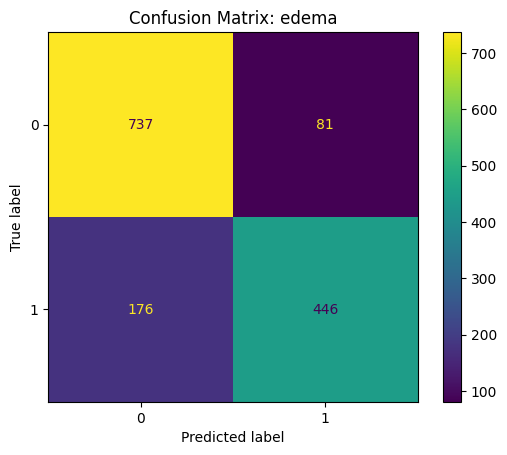

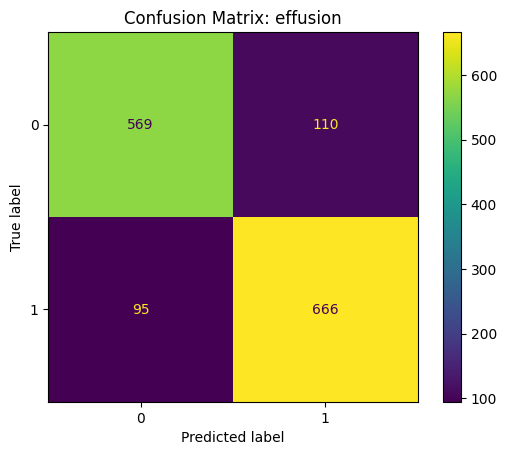

Metrics for dp0.2_wd0_lr5e-05_bs32: {'edema': {'precision': 0.8462998102466793, 'recall': 0.7170418006430869, 'f1': 0.7763272410791993, 'auroc': 0.9108149435137068, 'auprc': 0.8914379463923559, 'sensitivity': 0.7170418006430869, 'specificity': 0.9009779951100244}, 'effusion': {'precision': 0.8582474226804123, 'recall': 0.8751642575558476, 'f1': 0.8666232921275211, 'auroc': 0.9345040534603913, 'auprc': 0.938859111410123, 'sensitivity': 0.8751642575558476, 'specificity': 0.8379970544918999}}


In [11]:
for i in range(30, 33):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    if hyperparameters['batch_size'] == 64:
        continue
    execute_hyperparameter_combinations(hyperparameters)

In [12]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.2_wd0_lr0.0002_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 1/20: train_loss=0.5227, val_loss=0.4856


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 2/20: train_loss=0.4467, val_loss=0.4877


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 3/20: train_loss=0.4383, val_loss=0.5427


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 4/20: train_loss=0.4136, val_loss=0.4771


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 5/20: train_loss=0.3976, val_loss=0.4256


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 6/20: train_loss=0.3781, val_loss=0.4427


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 7/20: train_loss=0.3685, val_loss=0.4476


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 8/20: train_loss=0.3662, val_loss=0.4188


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 9/20: train_loss=0.3646, val_loss=0.4896


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 10/20: train_loss=0.3574, val_loss=0.4056


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 11/20: train_loss=0.3467, val_loss=0.4256


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.15it/s]


Epoch 12/20: train_loss=0.3421, val_loss=0.4328


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 13/20: train_loss=0.3307, val_loss=0.4255
Early stopping at epoch 13


Evaluating: 100%|██████████| 90/90 [01:14<00:00,  1.21it/s]


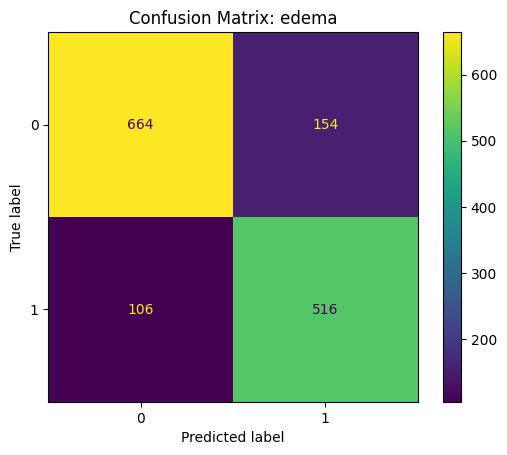

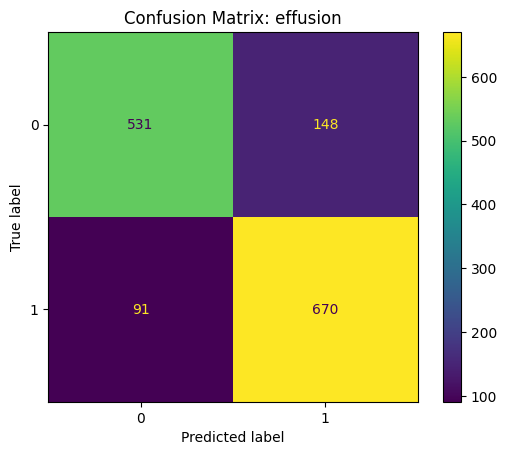

Metrics for dp0.2_wd0_lr0.0002_bs16: {'edema': {'precision': 0.7701492537313432, 'recall': 0.8295819935691319, 'f1': 0.7987616099071208, 'auroc': 0.8971041439005023, 'auprc': 0.8650142920003301, 'sensitivity': 0.8295819935691319, 'specificity': 0.8117359413202934}, 'effusion': {'precision': 0.8190709046454768, 'recall': 0.8804204993429697, 'f1': 0.8486383787207094, 'auroc': 0.9138158263969391, 'auprc': 0.9246030700592671, 'sensitivity': 0.8804204993429697, 'specificity': 0.7820324005891016}}
Running combination: dp0.2_wd0_lr0.0002_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 1/20: train_loss=0.4685, val_loss=0.4537


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 2/20: train_loss=0.4084, val_loss=0.4178


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 3/20: train_loss=0.3839, val_loss=0.4124


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 4/20: train_loss=0.3592, val_loss=0.4169


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 5/20: train_loss=0.3586, val_loss=0.4175


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 6/20: train_loss=0.3352, val_loss=0.3963


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 7/20: train_loss=0.3247, val_loss=0.4446


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 8/20: train_loss=0.3183, val_loss=0.4306


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 9/20: train_loss=0.3076, val_loss=0.4164
Early stopping at epoch 9


Evaluating: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


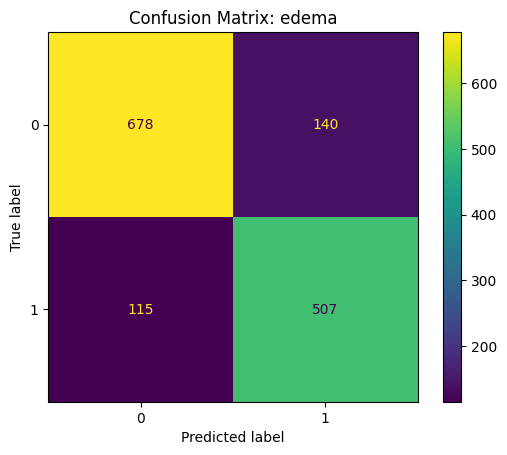

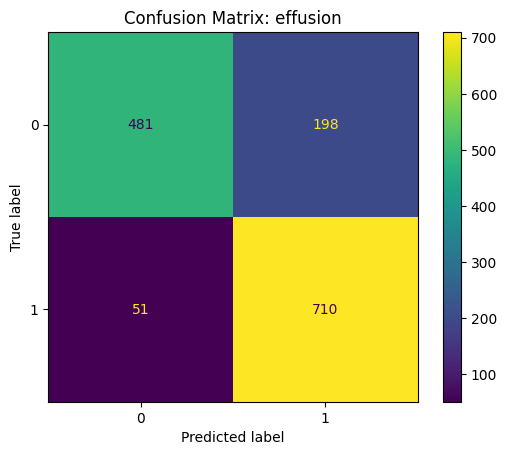

Metrics for dp0.2_wd0_lr0.0002_bs32: {'edema': {'precision': 0.7836166924265843, 'recall': 0.815112540192926, 'f1': 0.7990543735224587, 'auroc': 0.9077351237038027, 'auprc': 0.8768170140934508, 'sensitivity': 0.815112540192926, 'specificity': 0.8288508557457213}, 'effusion': {'precision': 0.7819383259911894, 'recall': 0.9329829172141918, 'f1': 0.8508088675853804, 'auroc': 0.9195210549641101, 'auprc': 0.9266987386932314, 'sensitivity': 0.9329829172141918, 'specificity': 0.7083946980854198}}


In [13]:
for i in range(33, 36):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    if hyperparameters['batch_size'] == 64:
        continue
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.2_wd0.01_lr1e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 1/20: train_loss=0.5133, val_loss=0.4557


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 2/20: train_loss=0.4042, val_loss=0.4204


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 3/20: train_loss=0.3659, val_loss=0.4022


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 4/20: train_loss=0.3412, val_loss=0.4013


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 5/20: train_loss=0.3236, val_loss=0.3813


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 6/20: train_loss=0.3024, val_loss=0.3995


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 7/20: train_loss=0.2933, val_loss=0.3896


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 8/20: train_loss=0.2792, val_loss=0.3775


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 9/20: train_loss=0.2655, val_loss=0.3875


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 10/20: train_loss=0.2480, val_loss=0.3951


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 11/20: train_loss=0.2349, val_loss=0.4004
Early stopping at epoch 11


Evaluating: 100%|██████████| 90/90 [01:15<00:00,  1.19it/s]


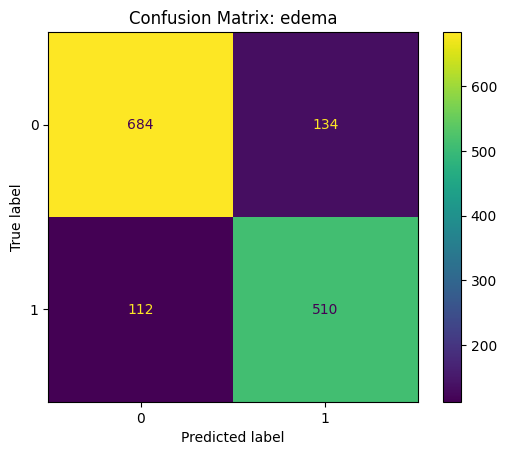

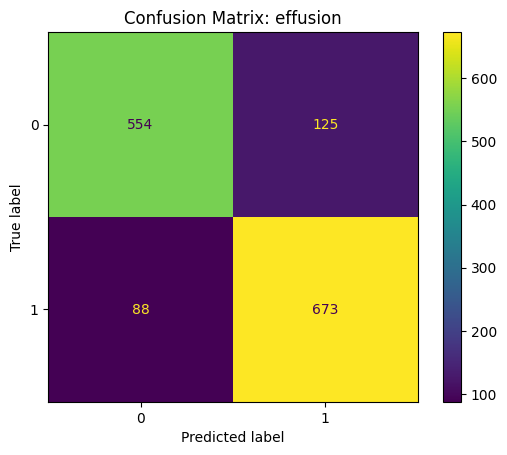

Metrics for dp0.2_wd0.01_lr1e-05_bs16: {'edema': {'precision': 0.7919254658385093, 'recall': 0.819935691318328, 'f1': 0.8056872037914692, 'auroc': 0.9147261377841021, 'auprc': 0.8822551687601674, 'sensitivity': 0.819935691318328, 'specificity': 0.8361858190709046}, 'effusion': {'precision': 0.843358395989975, 'recall': 0.8843626806833115, 'f1': 0.86337395766517, 'auroc': 0.9302831906703642, 'auprc': 0.9314742052698941, 'sensitivity': 0.8843626806833115, 'specificity': 0.8159057437407953}}
Running combination: dp0.2_wd0.01_lr1e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:39<00:00,  1.74s/it]


Epoch 1/20: train_loss=0.5409, val_loss=0.4715


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 2/20: train_loss=0.4276, val_loss=0.4242


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 3/20: train_loss=0.3875, val_loss=0.4183


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 4/20: train_loss=0.3616, val_loss=0.4248


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 5/20: train_loss=0.3472, val_loss=0.4090


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 6/20: train_loss=0.3303, val_loss=0.3914


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 7/20: train_loss=0.3167, val_loss=0.4070


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 8/20: train_loss=0.3030, val_loss=0.3841


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.74s/it]


Epoch 9/20: train_loss=0.2845, val_loss=0.4022


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 10/20: train_loss=0.2784, val_loss=0.4002


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 11/20: train_loss=0.2672, val_loss=0.4084
Early stopping at epoch 11


Evaluating: 100%|██████████| 45/45 [01:17<00:00,  1.71s/it]


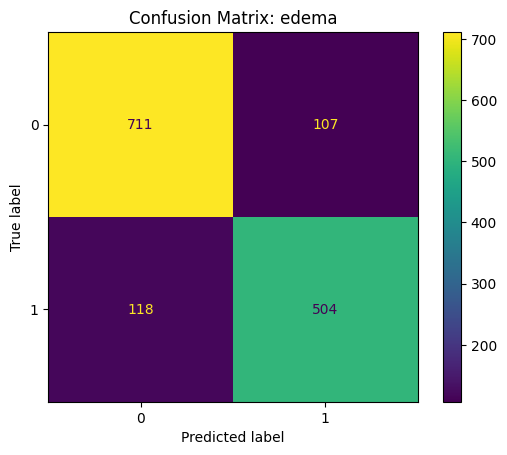

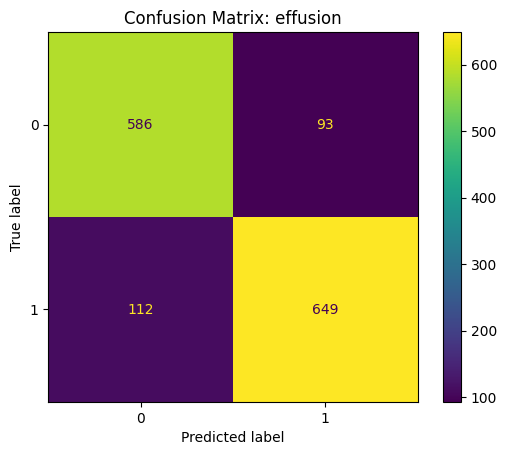

Metrics for dp0.2_wd0.01_lr1e-05_bs32: {'edema': {'precision': 0.8248772504091653, 'recall': 0.8102893890675241, 'f1': 0.8175182481751825, 'auroc': 0.9137375293830926, 'auprc': 0.8912736267213616, 'sensitivity': 0.8102893890675241, 'specificity': 0.8691931540342298}, 'effusion': {'precision': 0.8746630727762803, 'recall': 0.8528252299605782, 'f1': 0.863606121091151, 'auroc': 0.9337415500494467, 'auprc': 0.9369163762697782, 'sensitivity': 0.8528252299605782, 'specificity': 0.8630338733431517}}


In [14]:
for i in range(36, 39):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    if hyperparameters['batch_size'] == 64:
        continue
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.2_wd0.01_lr5e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


Epoch 1/20: train_loss=0.4621, val_loss=0.4511


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 2/20: train_loss=0.3781, val_loss=0.4089


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 3/20: train_loss=0.3436, val_loss=0.4126


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 4/20: train_loss=0.3190, val_loss=0.4267


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


Epoch 5/20: train_loss=0.3077, val_loss=0.3903


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.10it/s]


Epoch 6/20: train_loss=0.2807, val_loss=0.3946


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 7/20: train_loss=0.2577, val_loss=0.3949


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 8/20: train_loss=0.2466, val_loss=0.3787


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 9/20: train_loss=0.2162, val_loss=0.4057


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]


Epoch 10/20: train_loss=0.2003, val_loss=0.4349


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


Epoch 11/20: train_loss=0.1784, val_loss=0.4606
Early stopping at epoch 11


Evaluating: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


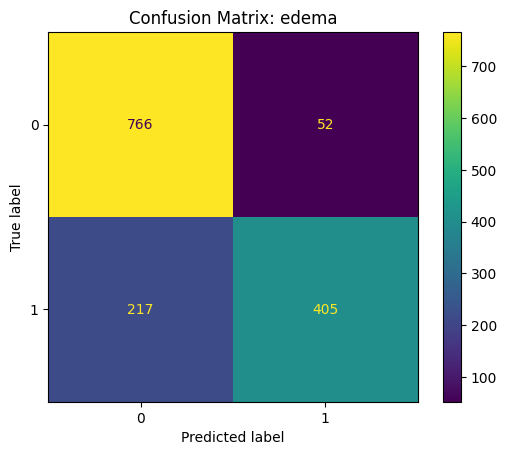

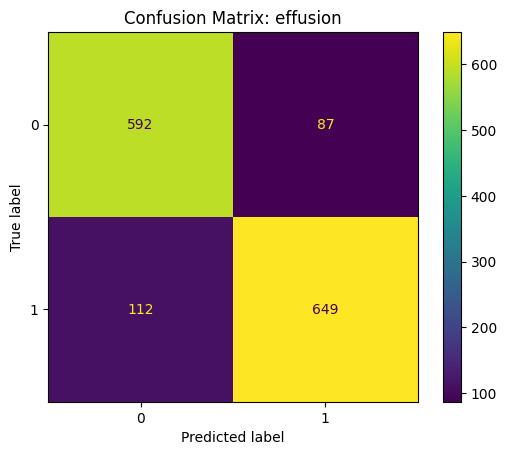

Metrics for dp0.2_wd0.01_lr5e-05_bs16: {'edema': {'precision': 0.8862144420131292, 'recall': 0.6511254019292605, 'f1': 0.7506950880444856, 'auroc': 0.8950974457346365, 'auprc': 0.8709384475558313, 'sensitivity': 0.6511254019292605, 'specificity': 0.9364303178484108}, 'effusion': {'precision': 0.8817934782608695, 'recall': 0.8528252299605782, 'f1': 0.8670674682698731, 'auroc': 0.9287949543175303, 'auprc': 0.9305635101451069, 'sensitivity': 0.8528252299605782, 'specificity': 0.8718703976435935}}
Running combination: dp0.2_wd0.01_lr5e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:42<00:00,  1.83s/it]


Epoch 1/20: train_loss=0.4776, val_loss=0.4321


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.83s/it]


Epoch 2/20: train_loss=0.3723, val_loss=0.4677


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Epoch 3/20: train_loss=0.3421, val_loss=0.3806


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.87s/it]


Epoch 4/20: train_loss=0.3202, val_loss=0.4291


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.89s/it]


Epoch 5/20: train_loss=0.3037, val_loss=0.3894


Validation: 100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Epoch 6/20: train_loss=0.2846, val_loss=0.4063
Early stopping at epoch 6


Evaluating: 100%|██████████| 45/45 [01:23<00:00,  1.85s/it]


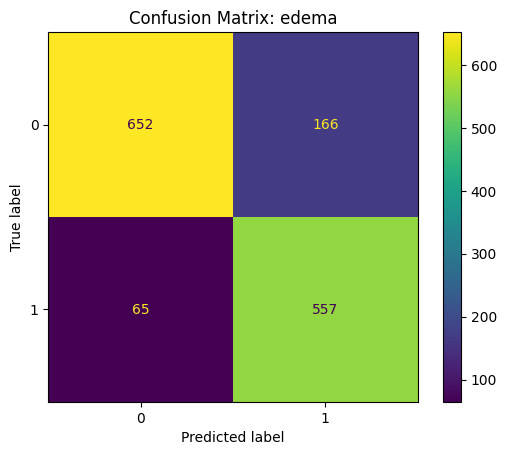

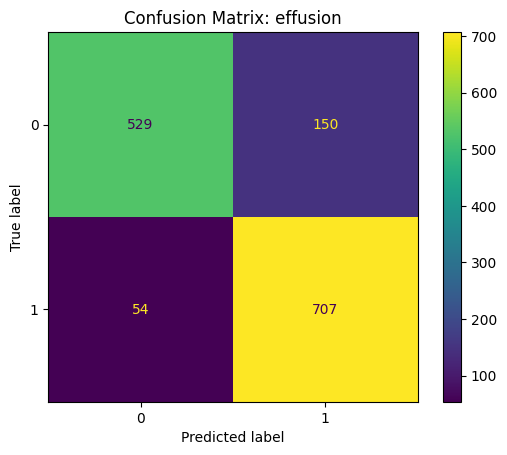

Metrics for dp0.2_wd0.01_lr5e-05_bs32: {'edema': {'precision': 0.7704011065006916, 'recall': 0.8954983922829582, 'f1': 0.8282527881040892, 'auroc': 0.922267470656216, 'auprc': 0.8959133040351566, 'sensitivity': 0.8954983922829582, 'specificity': 0.7970660146699267}, 'effusion': {'precision': 0.8249708284714119, 'recall': 0.9290407358738502, 'f1': 0.8739184177997528, 'auroc': 0.93262488896286, 'auprc': 0.9330198089593972, 'sensitivity': 0.9290407358738502, 'specificity': 0.7790868924889544}}


In [8]:
for i in range(39, 42):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    if hyperparameters['batch_size'] == 64:
        continue
    execute_hyperparameter_combinations(hyperparameters)

In [9]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.2_wd0.01_lr0.0002_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 1/20: train_loss=0.5684, val_loss=0.5112


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 2/20: train_loss=0.6395, val_loss=0.6412


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.12it/s]


Epoch 3/20: train_loss=0.6322, val_loss=0.5229


Validation: 100%|██████████| 45/45 [00:40<00:00,  1.10it/s]


Epoch 4/20: train_loss=0.6012, val_loss=0.5928
Early stopping at epoch 4


Evaluating: 100%|██████████| 90/90 [01:17<00:00,  1.17it/s]


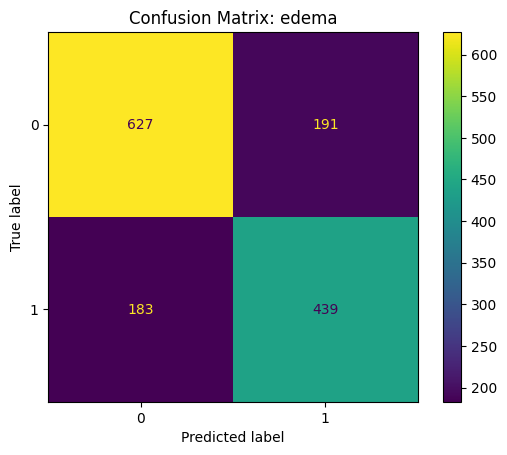

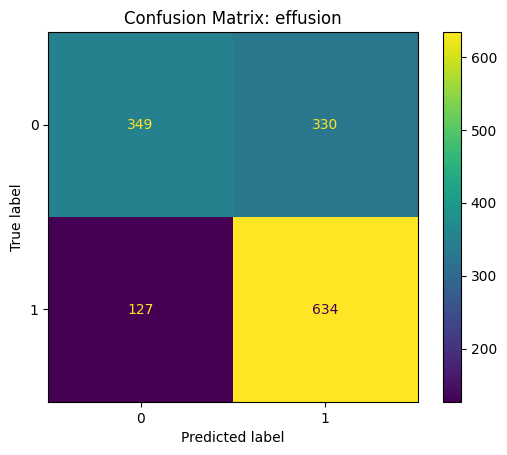

Metrics for dp0.2_wd0.01_lr0.0002_bs16: {'edema': {'precision': 0.6968253968253968, 'recall': 0.7057877813504824, 'f1': 0.7012779552715654, 'auroc': 0.8013761900643872, 'auprc': 0.7514866231467229, 'sensitivity': 0.7057877813504824, 'specificity': 0.7665036674816625}, 'effusion': {'precision': 0.6576763485477178, 'recall': 0.8331143232588699, 'f1': 0.735072463768116, 'auroc': 0.7777031616797525, 'auprc': 0.7997945619593227, 'sensitivity': 0.8331143232588699, 'specificity': 0.5139911634756995}}
Running combination: dp0.2_wd0.01_lr0.0002_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 1/20: train_loss=0.4743, val_loss=0.4921


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 2/20: train_loss=0.4061, val_loss=0.4703


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 3/20: train_loss=0.4116, val_loss=0.4773


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.71s/it]


Epoch 4/20: train_loss=0.3708, val_loss=0.4087


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 5/20: train_loss=0.3472, val_loss=0.4059


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 6/20: train_loss=0.3315, val_loss=0.4005


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 7/20: train_loss=0.3221, val_loss=0.3982


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.71s/it]


Epoch 8/20: train_loss=0.3210, val_loss=0.3966


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 9/20: train_loss=0.3100, val_loss=0.4347


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 10/20: train_loss=0.2978, val_loss=0.4415


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 11/20: train_loss=0.2904, val_loss=0.4006
Early stopping at epoch 11


Evaluating: 100%|██████████| 45/45 [01:17<00:00,  1.73s/it]


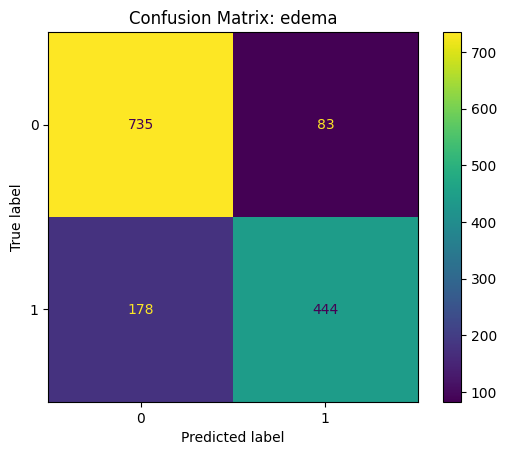

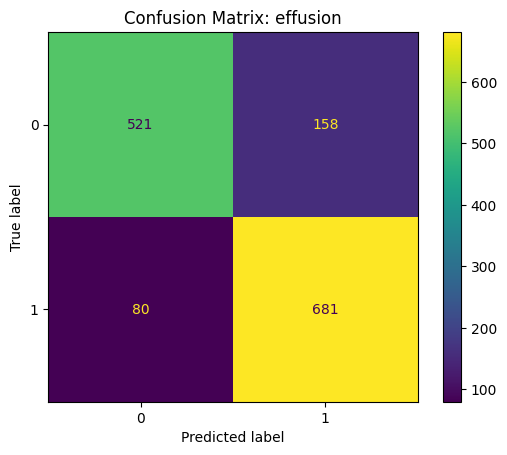

Metrics for dp0.2_wd0.01_lr0.0002_bs32: {'edema': {'precision': 0.8425047438330171, 'recall': 0.7138263665594855, 'f1': 0.7728459530026109, 'auroc': 0.9054945400514156, 'auprc': 0.8675240575476023, 'sensitivity': 0.7138263665594855, 'specificity': 0.8985330073349633}, 'effusion': {'precision': 0.8116805721096544, 'recall': 0.8948751642575559, 'f1': 0.85125, 'auroc': 0.9209821972871135, 'auprc': 0.92786834174345, 'sensitivity': 0.8948751642575559, 'specificity': 0.7673048600883653}}


In [10]:
for i in range(42, 45):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    if hyperparameters['batch_size'] == 64:
        continue
    execute_hyperparameter_combinations(hyperparameters)

In [11]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.2_wd0.1_lr1e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 1/20: train_loss=0.5187, val_loss=0.4645


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 2/20: train_loss=0.4034, val_loss=0.4154


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 3/20: train_loss=0.3672, val_loss=0.4103


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 4/20: train_loss=0.3408, val_loss=0.3920


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 5/20: train_loss=0.3263, val_loss=0.3850


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 6/20: train_loss=0.3084, val_loss=0.4005


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 7/20: train_loss=0.2930, val_loss=0.3866


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.15it/s]


Epoch 8/20: train_loss=0.2785, val_loss=0.3906
Early stopping at epoch 8


Evaluating: 100%|██████████| 90/90 [01:14<00:00,  1.21it/s]


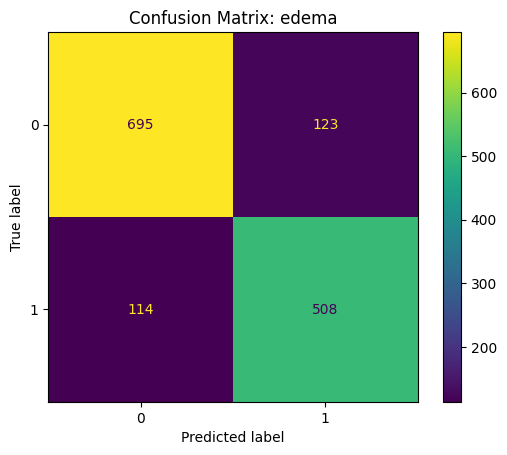

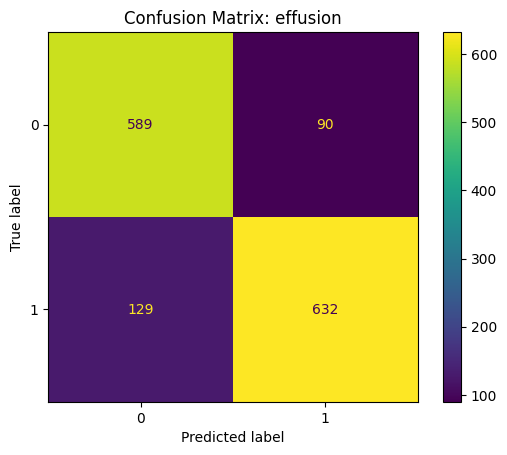

Metrics for dp0.2_wd0.1_lr1e-05_bs16: {'edema': {'precision': 0.8050713153724247, 'recall': 0.8167202572347267, 'f1': 0.810853950518755, 'auroc': 0.9140185850517694, 'auprc': 0.8934077129516905, 'sensitivity': 0.8167202572347267, 'specificity': 0.8496332518337408}, 'effusion': {'precision': 0.8753462603878116, 'recall': 0.8304862023653088, 'f1': 0.8523263654753878, 'auroc': 0.9301844909902675, 'auprc': 0.9336159338079751, 'sensitivity': 0.8304862023653088, 'specificity': 0.8674521354933726}}
Running combination: dp0.2_wd0.1_lr1e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 1/20: train_loss=0.5386, val_loss=0.4704


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 2/20: train_loss=0.4251, val_loss=0.4787


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 3/20: train_loss=0.3867, val_loss=0.4569


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 4/20: train_loss=0.3685, val_loss=0.4270


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 5/20: train_loss=0.3487, val_loss=0.4051


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 6/20: train_loss=0.3337, val_loss=0.4098


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 7/20: train_loss=0.3197, val_loss=0.3921


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Epoch 8/20: train_loss=0.3092, val_loss=0.3902


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 9/20: train_loss=0.2921, val_loss=0.3899


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 10/20: train_loss=0.2850, val_loss=0.3777


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 11/20: train_loss=0.2707, val_loss=0.3868


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 12/20: train_loss=0.2609, val_loss=0.4003


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 13/20: train_loss=0.2524, val_loss=0.4147
Early stopping at epoch 13


Evaluating: 100%|██████████| 45/45 [01:16<00:00,  1.70s/it]


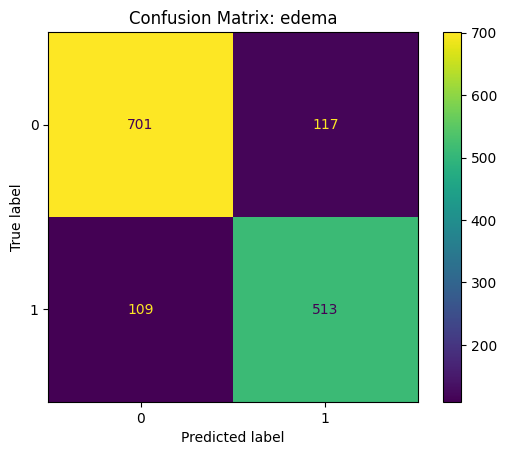

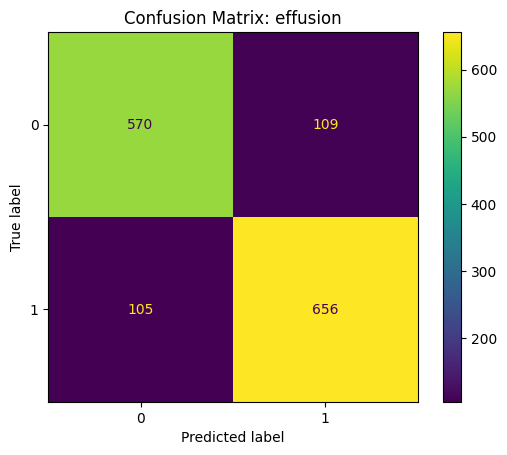

Metrics for dp0.2_wd0.1_lr1e-05_bs32: {'edema': {'precision': 0.8142857142857143, 'recall': 0.8247588424437299, 'f1': 0.8194888178913738, 'auroc': 0.9129297400136794, 'auprc': 0.8896156889245477, 'sensitivity': 0.8247588424437299, 'specificity': 0.8569682151589242}, 'effusion': {'precision': 0.857516339869281, 'recall': 0.8620236530880421, 'f1': 0.8597640891218873, 'auroc': 0.931705627236467, 'auprc': 0.9362135204580782, 'sensitivity': 0.8620236530880421, 'specificity': 0.8394698085419735}}


In [12]:
for i in range(45, 48):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    if hyperparameters['batch_size'] == 64:
        continue
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.2_wd0.1_lr5e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 1/20: train_loss=0.4581, val_loss=0.4443


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 2/20: train_loss=0.3766, val_loss=0.3971


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]


Epoch 3/20: train_loss=0.3422, val_loss=0.3966


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 4/20: train_loss=0.3246, val_loss=0.3856


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 5/20: train_loss=0.3025, val_loss=0.4083


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 6/20: train_loss=0.2918, val_loss=0.3926


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 7/20: train_loss=0.2712, val_loss=0.3740


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 8/20: train_loss=0.2476, val_loss=0.4386


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 9/20: train_loss=0.2358, val_loss=0.4332


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]


Epoch 10/20: train_loss=0.2132, val_loss=0.4656
Early stopping at epoch 10


Evaluating: 100%|██████████| 90/90 [01:16<00:00,  1.18it/s]


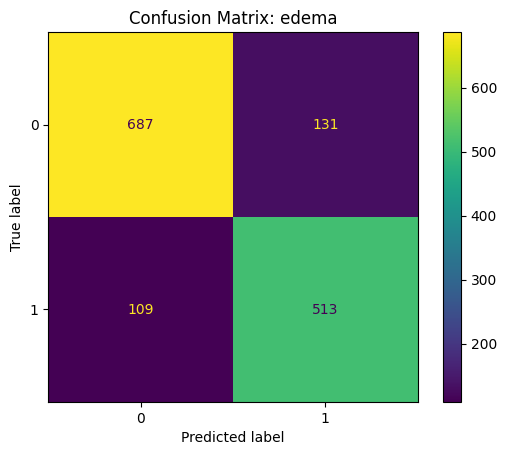

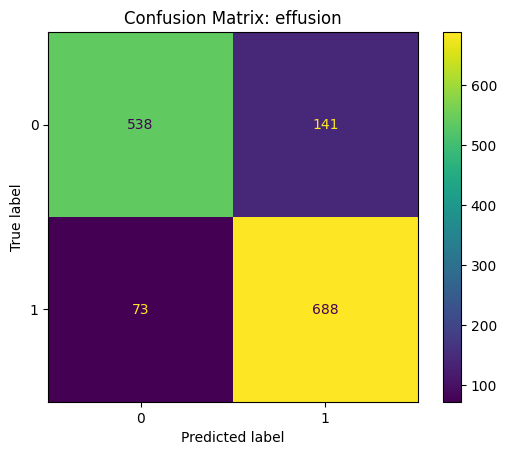

Metrics for dp0.2_wd0.1_lr5e-05_bs16: {'edema': {'precision': 0.796583850931677, 'recall': 0.8247588424437299, 'f1': 0.8104265402843602, 'auroc': 0.9086844236196825, 'auprc': 0.8699084751806163, 'sensitivity': 0.8247588424437299, 'specificity': 0.8398533007334963}, 'effusion': {'precision': 0.8299155609167672, 'recall': 0.9040735873850198, 'f1': 0.8654088050314466, 'auroc': 0.9283788674308473, 'auprc': 0.9317285274301401, 'sensitivity': 0.9040735873850198, 'specificity': 0.792341678939617}}
Running combination: dp0.2_wd0.1_lr5e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 1/20: train_loss=0.4691, val_loss=0.4288


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 2/20: train_loss=0.3807, val_loss=0.4394


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 3/20: train_loss=0.3513, val_loss=0.4209


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 4/20: train_loss=0.3262, val_loss=0.4394


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Epoch 5/20: train_loss=0.3116, val_loss=0.3785


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.71s/it]


Epoch 6/20: train_loss=0.2950, val_loss=0.3872


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Epoch 7/20: train_loss=0.2640, val_loss=0.4172


Validation: 100%|██████████| 23/23 [00:39<00:00,  1.70s/it]


Epoch 8/20: train_loss=0.2460, val_loss=0.4343
Early stopping at epoch 8


Evaluating: 100%|██████████| 45/45 [01:15<00:00,  1.68s/it]


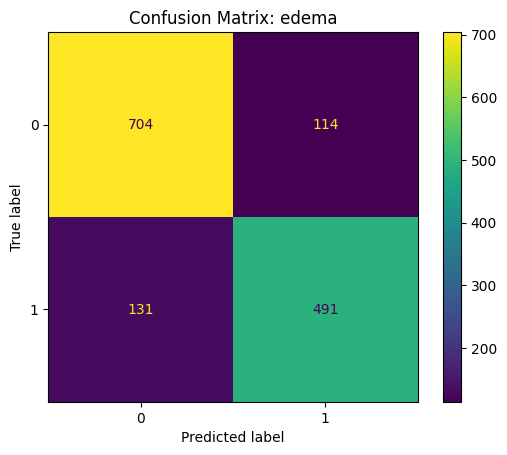

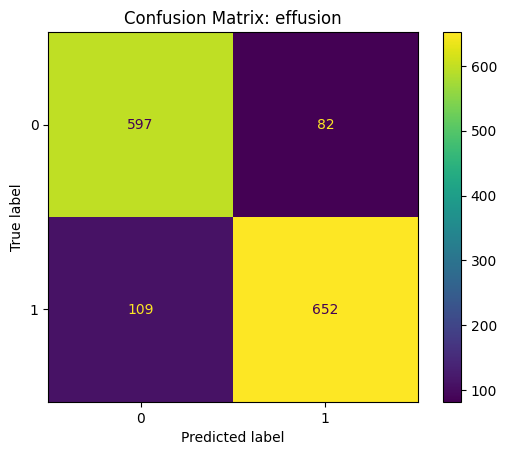

Metrics for dp0.2_wd0.1_lr5e-05_bs32: {'edema': {'precision': 0.8115702479338843, 'recall': 0.7893890675241158, 'f1': 0.8003259983700082, 'auroc': 0.9080240410695053, 'auprc': 0.8838644319782619, 'sensitivity': 0.7893890675241158, 'specificity': 0.8606356968215159}, 'effusion': {'precision': 0.888283378746594, 'recall': 0.8567674113009198, 'f1': 0.8722408026755852, 'auroc': 0.9320288203065885, 'auprc': 0.934037021272792, 'sensitivity': 0.8567674113009198, 'specificity': 0.8792341678939617}}
Running combination: dp0.2_wd0.1_lr0.0002_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:38<00:00,  1.17it/s]


Epoch 1/20: train_loss=0.6719, val_loss=0.6802


Validation: 100%|██████████| 45/45 [00:38<00:00,  1.17it/s]


Epoch 2/20: train_loss=0.6825, val_loss=0.6793


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 3/20: train_loss=0.6824, val_loss=0.6904


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Epoch 4/20: train_loss=0.6791, val_loss=0.6800


Validation: 100%|██████████| 45/45 [00:39<00:00,  1.13it/s]


Epoch 5/20: train_loss=0.6762, val_loss=0.7011
Early stopping at epoch 5


Evaluating: 100%|██████████| 90/90 [01:15<00:00,  1.19it/s]


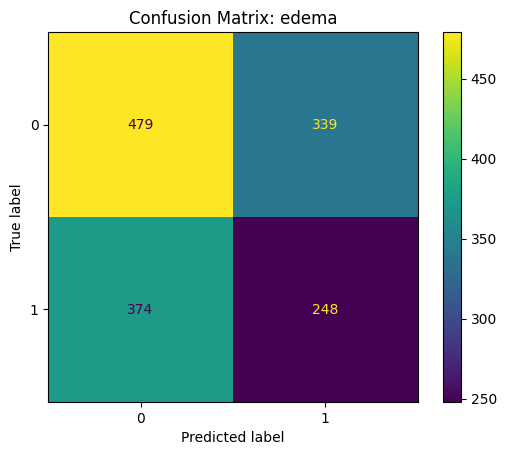

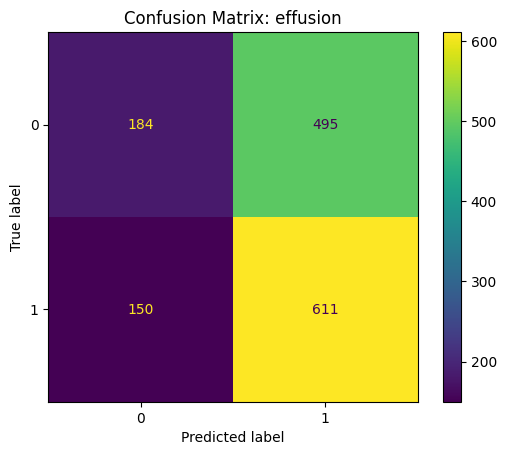

Metrics for dp0.2_wd0.1_lr0.0002_bs16: {'edema': {'precision': 0.42248722316865417, 'recall': 0.3987138263665595, 'f1': 0.41025641025641024, 'auroc': 0.5029579635060024, 'auprc': 0.4181445200752936, 'sensitivity': 0.3987138263665595, 'specificity': 0.5855745721271394}, 'effusion': {'precision': 0.5524412296564195, 'recall': 0.8028909329829172, 'f1': 0.6545259775040171, 'auroc': 0.4961749035742831, 'auprc': 0.5035243176383905, 'sensitivity': 0.8028909329829172, 'specificity': 0.2709867452135493}}
Running combination: dp0.2_wd0.1_lr0.0002_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 1/20: train_loss=0.5020, val_loss=0.4644


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Epoch 2/20: train_loss=0.4303, val_loss=0.4966


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 3/20: train_loss=0.3979, val_loss=0.4288


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 4/20: train_loss=0.3731, val_loss=0.4274


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 5/20: train_loss=0.3602, val_loss=0.4102


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 6/20: train_loss=0.3559, val_loss=0.4115


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 7/20: train_loss=0.3362, val_loss=0.4271


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 8/20: train_loss=0.3299, val_loss=0.4271
Early stopping at epoch 8


Evaluating: 100%|██████████| 45/45 [01:18<00:00,  1.74s/it]


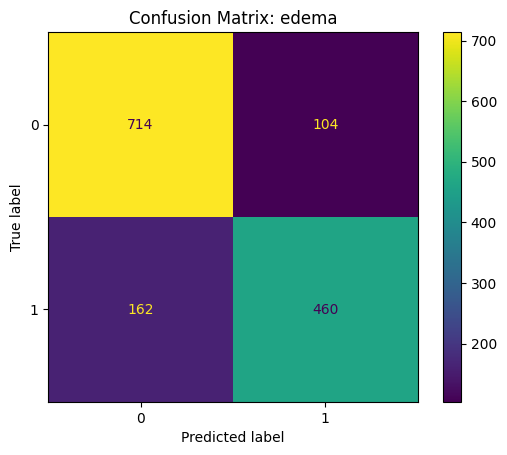

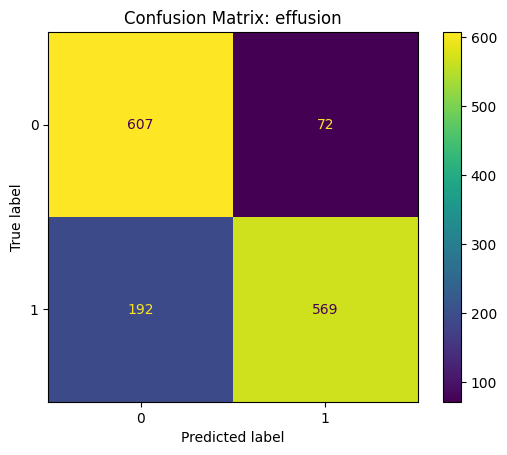

Metrics for dp0.2_wd0.1_lr0.0002_bs32: {'edema': {'precision': 0.8156028368794326, 'recall': 0.7395498392282959, 'f1': 0.7757166947723441, 'auroc': 0.9019666035110339, 'auprc': 0.8648110114516925, 'sensitivity': 0.7395498392282959, 'specificity': 0.8728606356968215}, 'effusion': {'precision': 0.8876755070202809, 'recall': 0.7477003942181341, 'f1': 0.81169757489301, 'auroc': 0.9180057245814456, 'auprc': 0.9247287814987457, 'sensitivity': 0.7477003942181341, 'specificity': 0.8939617083946981}}


In [13]:
for i in range(48, len(hyperparameter_combinations)):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['patience'] = 3
    if hyperparameters['batch_size'] == 64:
        continue
    execute_hyperparameter_combinations(hyperparameters)

In [9]:
remaining_combos = []
# need to run batch size 64 for these: dp0.2_wd0_lr1e-05, dp0.2_wd0_lr5e-05, dp0.2_wd0_lr0.0002, dp0.2_wd0.01_lr1e-05, dp0.2_wd0.01_lr5e-05, dp0.2_wd0.01_lr0.0002, dp0.2_wd0.1_lr1e-05, dp0.2_wd0.1_lr5e-05, dp0.2_wd0.1_lr0.0002
for dp in [0.2]:
    for wd in [0, 0.01, 0.1]:
        for lr in [1e-5, 5e-5, 2e-4]:
            for bs in [64]:
                remaining_combos.append({
                    'dropout_rate': dp,
                    'weight_decay': wd,
                    'learning_rate': lr,
                    'batch_size': bs,
                    'num_epochs': 20
                })

Running combination: dp0.2_wd0_lr1e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:48<00:00,  4.05s/it]


Epoch 1/20: train_loss=0.5984, val_loss=0.5112


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.88s/it]


Epoch 2/20: train_loss=0.4621, val_loss=0.4594


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.86s/it]


Epoch 3/20: train_loss=0.4141, val_loss=0.4846


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


Epoch 4/20: train_loss=0.3872, val_loss=0.4365


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]


Epoch 5/20: train_loss=0.3736, val_loss=0.4231


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.98s/it]


Epoch 6/20: train_loss=0.3596, val_loss=0.4273


Validation: 100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Epoch 7/20: train_loss=0.3448, val_loss=0.4111


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.94s/it]


Epoch 8/20: train_loss=0.3299, val_loss=0.4100


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 9/20: train_loss=0.3218, val_loss=0.4038


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 10/20: train_loss=0.3076, val_loss=0.3937


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.83s/it]


Epoch 11/20: train_loss=0.3068, val_loss=0.3944


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 12/20: train_loss=0.2936, val_loss=0.3887


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.80s/it]


Epoch 13/20: train_loss=0.2864, val_loss=0.3808


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 14/20: train_loss=0.2771, val_loss=0.3978


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.83s/it]


Epoch 15/20: train_loss=0.2745, val_loss=0.4027


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 16/20: train_loss=0.2614, val_loss=0.3930
Early stopping at epoch 16


Evaluating: 100%|██████████| 23/23 [01:28<00:00,  3.84s/it]


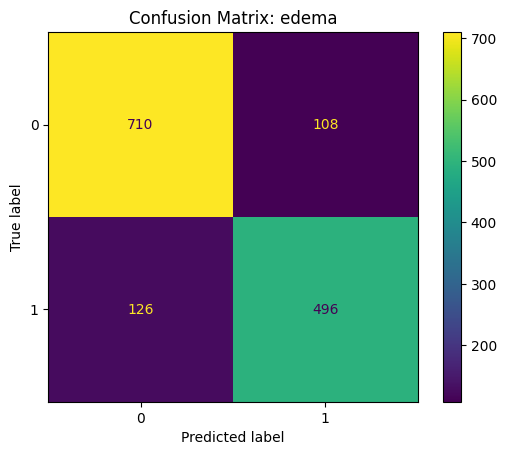

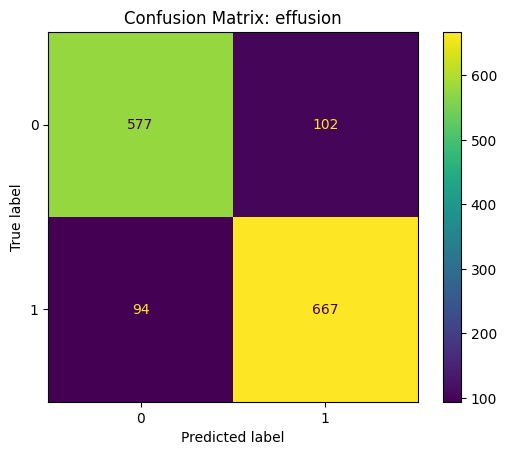

Metrics for dp0.2_wd0_lr1e-05_bs64: {'edema': {'precision': 0.8211920529801324, 'recall': 0.797427652733119, 'f1': 0.8091353996737357, 'auroc': 0.9196161133342244, 'auprc': 0.9003537080295921, 'sensitivity': 0.797427652733119, 'specificity': 0.8679706601466992}, 'effusion': {'precision': 0.8673602080624188, 'recall': 0.8764783180026281, 'f1': 0.8718954248366013, 'auroc': 0.9337009090047007, 'auprc': 0.9383642394390366, 'sensitivity': 0.8764783180026281, 'specificity': 0.8497790868924889}}
Running combination: dp0.2_wd0_lr5e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:47<00:00,  3.94s/it]


Epoch 1/20: train_loss=0.4855, val_loss=0.4461


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.84s/it]


Epoch 2/20: train_loss=0.3843, val_loss=0.4097


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


Epoch 3/20: train_loss=0.3446, val_loss=0.3864


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


Epoch 4/20: train_loss=0.3235, val_loss=0.4088


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.90s/it]


Epoch 5/20: train_loss=0.3024, val_loss=0.4085


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.89s/it]


Epoch 6/20: train_loss=0.3043, val_loss=0.4224
Early stopping at epoch 6


Evaluating: 100%|██████████| 23/23 [01:25<00:00,  3.73s/it]


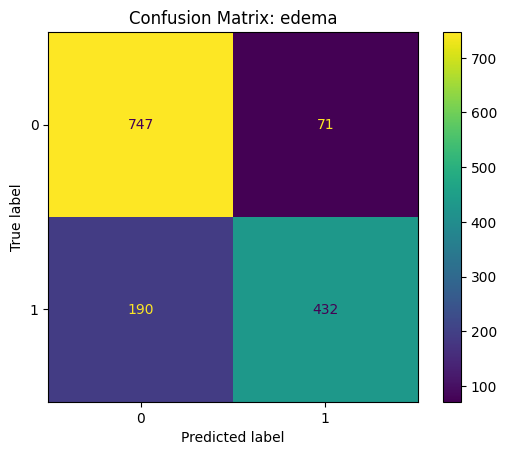

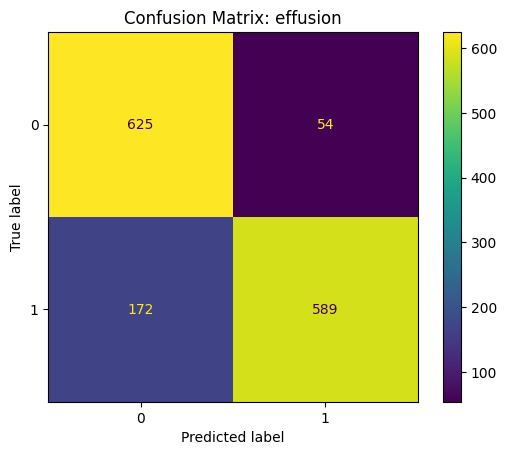

Metrics for dp0.2_wd0_lr5e-05_bs64: {'edema': {'precision': 0.8588469184890656, 'recall': 0.6945337620578779, 'f1': 0.768, 'auroc': 0.9121592937051392, 'auprc': 0.8946687112467927, 'sensitivity': 0.6945337620578779, 'specificity': 0.91320293398533}, 'effusion': {'precision': 0.9160186625194401, 'recall': 0.7739816031537451, 'f1': 0.8390313390313391, 'auroc': 0.932990658365572, 'auprc': 0.9371946974079487, 'sensitivity': 0.7739816031537451, 'specificity': 0.9204712812960235}}
Running combination: dp0.2_wd0_lr0.0002_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 1/20: train_loss=0.5268, val_loss=0.4470


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]


Epoch 2/20: train_loss=0.4159, val_loss=0.4523


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.06s/it]


Epoch 3/20: train_loss=0.3808, val_loss=0.4360


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.07s/it]


Epoch 4/20: train_loss=0.3471, val_loss=0.4304


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]


Epoch 5/20: train_loss=0.3393, val_loss=0.3837


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it]


Epoch 6/20: train_loss=0.3171, val_loss=0.4112


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]


Epoch 7/20: train_loss=0.3040, val_loss=0.4140


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 8/20: train_loss=0.2922, val_loss=0.4178
Early stopping at epoch 8


Evaluating: 100%|██████████| 23/23 [01:30<00:00,  3.94s/it]


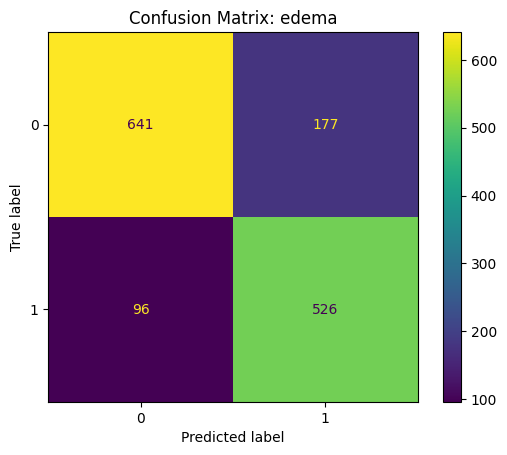

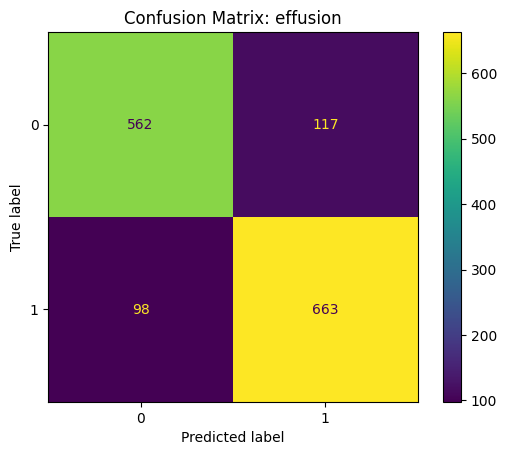

Metrics for dp0.2_wd0_lr0.0002_bs64: {'edema': {'precision': 0.748221906116643, 'recall': 0.8456591639871383, 'f1': 0.7939622641509434, 'auroc': 0.9008227265937626, 'auprc': 0.8732721732388734, 'sensitivity': 0.8456591639871383, 'specificity': 0.7836185819070904}, 'effusion': {'precision': 0.85, 'recall': 0.871222076215506, 'f1': 0.8604802076573653, 'auroc': 0.9212918433423194, 'auprc': 0.9229452900585471, 'sensitivity': 0.871222076215506, 'specificity': 0.8276877761413843}}


In [9]:
for i in range(0, 3):
    hyperparameters = remaining_combos[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)

In [10]:
import time

minutes_to_wait = 30
time.sleep(minutes_to_wait * 60)

Running combination: dp0.2_wd0.01_lr1e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 1/20: train_loss=0.6037, val_loss=0.5146


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]


Epoch 2/20: train_loss=0.4677, val_loss=0.4740


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


Epoch 3/20: train_loss=0.4216, val_loss=0.4421


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.99s/it]


Epoch 4/20: train_loss=0.3964, val_loss=0.4290


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.87s/it]


Epoch 5/20: train_loss=0.3729, val_loss=0.4205


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.01s/it]


Epoch 6/20: train_loss=0.3561, val_loss=0.4167


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.91s/it]


Epoch 7/20: train_loss=0.3477, val_loss=0.4023


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]


Epoch 8/20: train_loss=0.3324, val_loss=0.4149


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]


Epoch 9/20: train_loss=0.3198, val_loss=0.4113


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.94s/it]


Epoch 10/20: train_loss=0.3098, val_loss=0.4152
Early stopping at epoch 10


Evaluating: 100%|██████████| 23/23 [01:28<00:00,  3.85s/it]


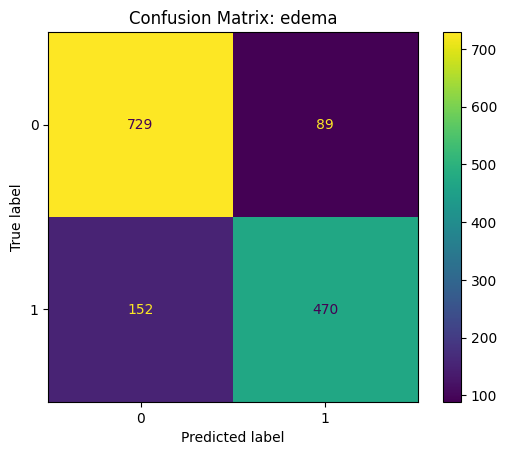

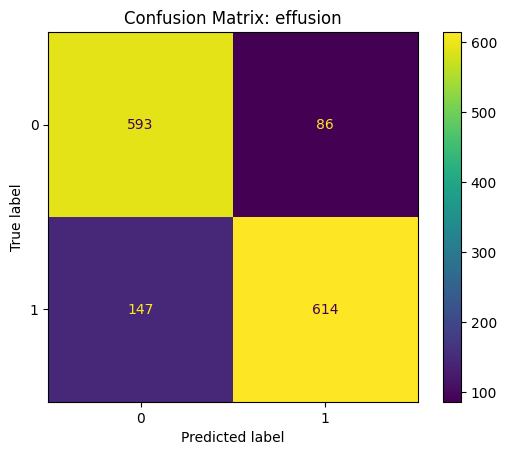

Metrics for dp0.2_wd0.01_lr1e-05_bs64: {'edema': {'precision': 0.8407871198568873, 'recall': 0.7556270096463023, 'f1': 0.7959356477561389, 'auroc': 0.9041580515570091, 'auprc': 0.8830613917212935, 'sensitivity': 0.7556270096463023, 'specificity': 0.89119804400978}, 'effusion': {'precision': 0.8771428571428571, 'recall': 0.8068331143232589, 'f1': 0.840520191649555, 'auroc': 0.9255146414201915, 'auprc': 0.9318166078468328, 'sensitivity': 0.8068331143232589, 'specificity': 0.8733431516936672}}
Running combination: dp0.2_wd0.01_lr5e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:49<00:00,  4.09s/it]


Epoch 1/20: train_loss=0.4946, val_loss=0.4516


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 2/20: train_loss=0.3815, val_loss=0.4970


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.13s/it]


Epoch 3/20: train_loss=0.3547, val_loss=0.3992


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.13s/it]


Epoch 4/20: train_loss=0.3258, val_loss=0.3895


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 5/20: train_loss=0.3058, val_loss=0.3892


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 6/20: train_loss=0.2925, val_loss=0.3982


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.11s/it]


Epoch 7/20: train_loss=0.2704, val_loss=0.3920


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


Epoch 8/20: train_loss=0.2532, val_loss=0.4045
Early stopping at epoch 8


Evaluating: 100%|██████████| 23/23 [01:31<00:00,  3.98s/it]


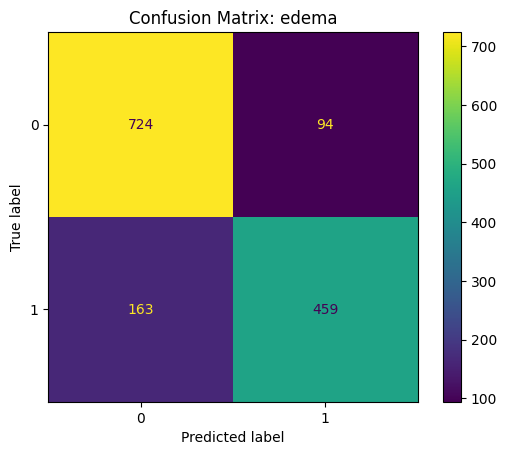

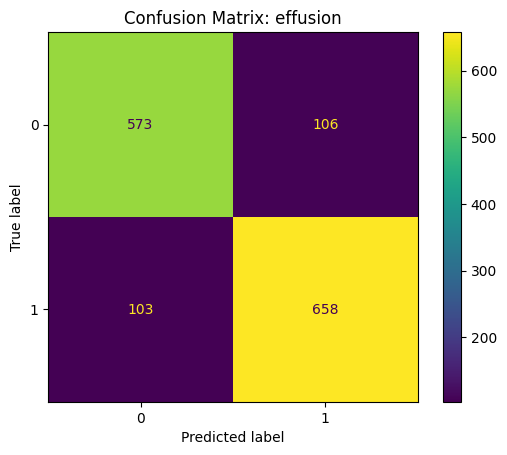

Metrics for dp0.2_wd0.01_lr5e-05_bs64: {'edema': {'precision': 0.8300180831826401, 'recall': 0.7379421221864951, 'f1': 0.7812765957446809, 'auroc': 0.9082422031619745, 'auprc': 0.8839787637155487, 'sensitivity': 0.7379421221864951, 'specificity': 0.8850855745721271}, 'effusion': {'precision': 0.8612565445026178, 'recall': 0.8646517739816032, 'f1': 0.8629508196721312, 'auroc': 0.9292729704152547, 'auprc': 0.9296466118344039, 'sensitivity': 0.8646517739816032, 'specificity': 0.8438880706921944}}
Running combination: dp0.2_wd0.01_lr0.0002_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


Epoch 1/20: train_loss=0.4774, val_loss=0.4651


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.89s/it]


Epoch 2/20: train_loss=0.3893, val_loss=0.4267


Training:   0%|          | 0/79 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [11]:
for i in range(3, 6):
    hyperparameters = remaining_combos[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.2_wd0.01_lr0.0002_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:54<00:00,  4.50s/it]


Epoch 1/20: train_loss=0.4999, val_loss=0.5028


Validation: 100%|██████████| 12/12 [00:51<00:00,  4.29s/it]


Epoch 2/20: train_loss=0.3963, val_loss=0.4260


Validation: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]


Epoch 3/20: train_loss=0.3655, val_loss=0.4100


Validation: 100%|██████████| 12/12 [00:51<00:00,  4.33s/it]


Epoch 4/20: train_loss=0.3467, val_loss=0.4231


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.16s/it]


Epoch 5/20: train_loss=0.3410, val_loss=0.4117


Validation: 100%|██████████| 12/12 [00:50<00:00,  4.17s/it]


Epoch 6/20: train_loss=0.3258, val_loss=0.4158
Early stopping at epoch 6


Evaluating: 100%|██████████| 23/23 [01:37<00:00,  4.26s/it]


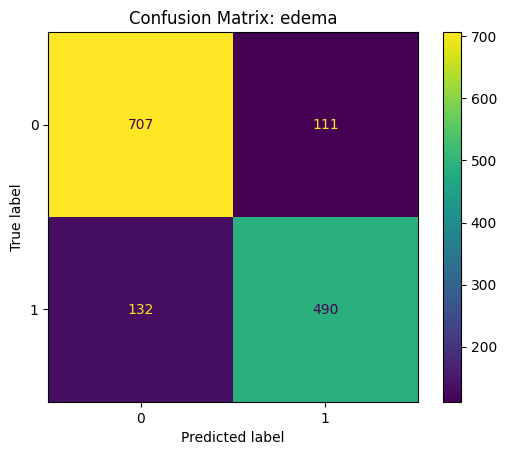

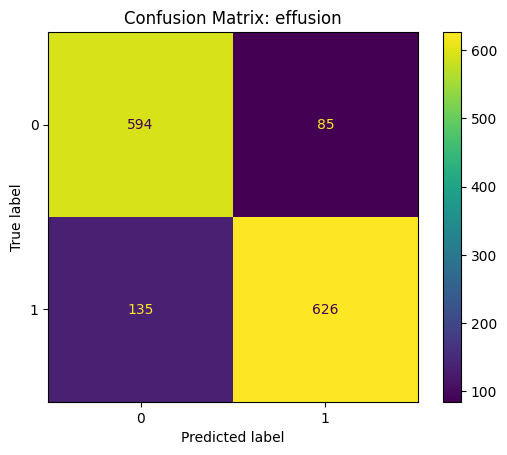

Metrics for dp0.2_wd0.01_lr0.0002_bs64: {'edema': {'precision': 0.8153078202995009, 'recall': 0.7877813504823151, 'f1': 0.8013082583810303, 'auroc': 0.9062531938144169, 'auprc': 0.878432401745405, 'sensitivity': 0.7877813504823151, 'specificity': 0.8643031784841075}, 'effusion': {'precision': 0.8804500703234881, 'recall': 0.8226018396846255, 'f1': 0.8505434782608695, 'auroc': 0.9264455148736548, 'auprc': 0.9311945655732159, 'sensitivity': 0.8226018396846255, 'specificity': 0.8748159057437408}}
Running combination: dp0.2_wd0.1_lr1e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]


Epoch 1/20: train_loss=0.6037, val_loss=0.5158


Training:  51%|█████     | 40/79 [07:26<07:05, 10.91s/it]

In [ ]:
for i in range(5, 7):
    hyperparameters = remaining_combos[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)

Running combination: dp0.2_wd0.1_lr1e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:49<00:00,  4.15s/it]


Epoch 1/20: train_loss=0.5983, val_loss=0.5105


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.14s/it]


Epoch 2/20: train_loss=0.4594, val_loss=0.4586


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.16s/it]


Epoch 3/20: train_loss=0.4137, val_loss=0.4403


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.08s/it]


Epoch 4/20: train_loss=0.3857, val_loss=0.4203


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.85s/it]


Epoch 5/20: train_loss=0.3660, val_loss=0.4157


Validation: 100%|██████████| 12/12 [00:49<00:00,  4.15s/it]


Epoch 6/20: train_loss=0.3547, val_loss=0.4151


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


Epoch 7/20: train_loss=0.3425, val_loss=0.4219


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


Epoch 8/20: train_loss=0.3310, val_loss=0.4169


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 9/20: train_loss=0.3225, val_loss=0.4031


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 10/20: train_loss=0.3069, val_loss=0.3946


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]


Epoch 11/20: train_loss=0.2976, val_loss=0.3978


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 12/20: train_loss=0.2923, val_loss=0.4287


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]


Epoch 13/20: train_loss=0.2806, val_loss=0.3911


Validation: 100%|██████████| 12/12 [00:46<00:00,  3.91s/it]


Epoch 14/20: train_loss=0.2742, val_loss=0.4008


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.98s/it]


Epoch 15/20: train_loss=0.2692, val_loss=0.3997


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.76s/it]


Epoch 16/20: train_loss=0.2567, val_loss=0.4092
Early stopping at epoch 16


Evaluating: 100%|██████████| 23/23 [01:31<00:00,  3.97s/it]


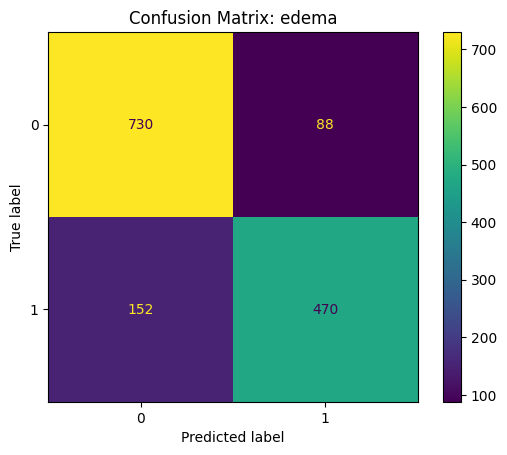

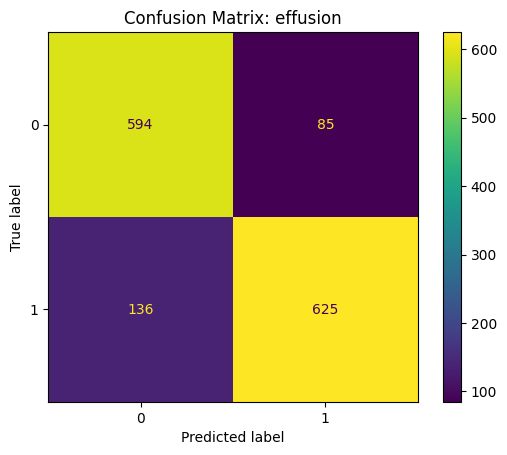

Metrics for dp0.2_wd0.1_lr1e-05_bs64: {'edema': {'precision': 0.8422939068100358, 'recall': 0.7556270096463023, 'f1': 0.7966101694915254, 'auroc': 0.9144431166911691, 'auprc': 0.8926766358664673, 'sensitivity': 0.7556270096463023, 'specificity': 0.8924205378973105}, 'effusion': {'precision': 0.8802816901408451, 'recall': 0.8212877792378449, 'f1': 0.849762066621346, 'auroc': 0.9326500477048454, 'auprc': 0.9379553108114438, 'sensitivity': 0.8212877792378449, 'specificity': 0.8748159057437408}}
Running combination: dp0.2_wd0.1_lr5e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:48<00:00,  4.05s/it]


Epoch 1/20: train_loss=0.4912, val_loss=0.4531


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it]


Epoch 2/20: train_loss=0.3843, val_loss=0.4187


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it]


Epoch 3/20: train_loss=0.3478, val_loss=0.3986


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.02s/it]


Epoch 4/20: train_loss=0.3227, val_loss=0.4184


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.02s/it]


Epoch 5/20: train_loss=0.3076, val_loss=0.3952


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it]


Epoch 6/20: train_loss=0.2847, val_loss=0.3894


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it]


Epoch 7/20: train_loss=0.2621, val_loss=0.3857


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.06s/it]


Epoch 8/20: train_loss=0.2434, val_loss=0.4111


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]


Epoch 9/20: train_loss=0.2304, val_loss=0.3843


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it]


Epoch 10/20: train_loss=0.2213, val_loss=0.4651


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.00s/it]


Epoch 11/20: train_loss=0.1958, val_loss=0.4234


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.07s/it]


Epoch 12/20: train_loss=0.1792, val_loss=0.4121
Early stopping at epoch 12


Evaluating: 100%|██████████| 23/23 [01:31<00:00,  3.98s/it]


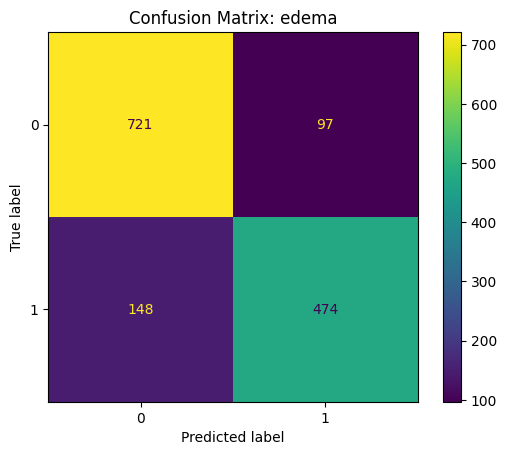

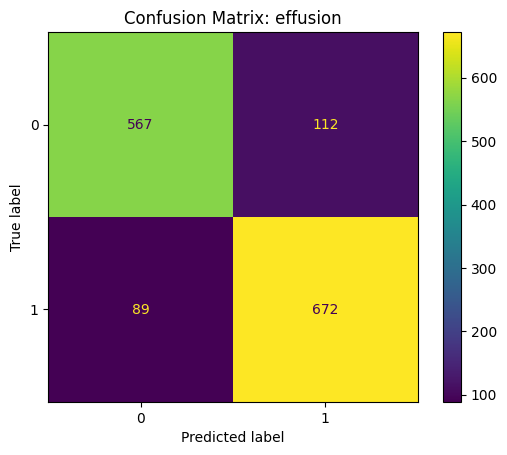

Metrics for dp0.2_wd0.1_lr5e-05_bs64: {'edema': {'precision': 0.830122591943958, 'recall': 0.7620578778135049, 'f1': 0.7946353730092205, 'auroc': 0.9083778174356717, 'auprc': 0.8816241113148252, 'sensitivity': 0.7620578778135049, 'specificity': 0.8814180929095354}, 'effusion': {'precision': 0.8571428571428571, 'recall': 0.8830486202365309, 'f1': 0.8699029126213592, 'auroc': 0.9310437587934641, 'auprc': 0.9364785810942293, 'sensitivity': 0.8830486202365309, 'specificity': 0.8350515463917526}}
Running combination: dp0.2_wd0.1_lr0.0002_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it]


Epoch 1/20: train_loss=0.4914, val_loss=0.4444


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.07s/it]


Epoch 2/20: train_loss=0.3977, val_loss=0.4455


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.02s/it]


Epoch 3/20: train_loss=0.3741, val_loss=0.4114


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.04s/it]


Epoch 4/20: train_loss=0.3504, val_loss=0.4414


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.02s/it]


Epoch 5/20: train_loss=0.3478, val_loss=0.4073


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.02s/it]


Epoch 6/20: train_loss=0.3126, val_loss=0.3814


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.06s/it]


Epoch 7/20: train_loss=0.3116, val_loss=0.4142


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.07s/it]


Epoch 8/20: train_loss=0.2975, val_loss=0.4269


Validation: 100%|██████████| 12/12 [00:48<00:00,  4.03s/it]


Epoch 9/20: train_loss=0.2890, val_loss=0.4051
Early stopping at epoch 9


Evaluating: 100%|██████████| 23/23 [01:30<00:00,  3.95s/it]


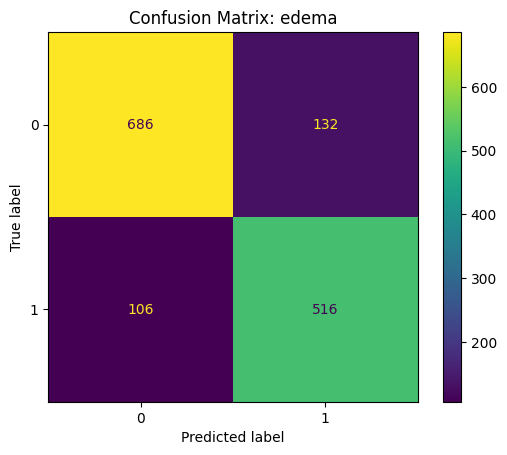

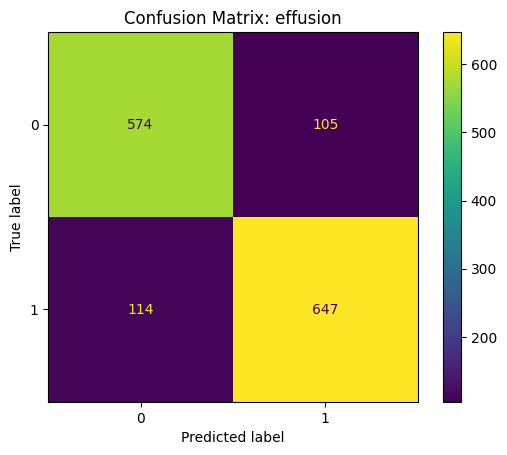

Metrics for dp0.2_wd0.1_lr0.0002_bs64: {'edema': {'precision': 0.7962962962962963, 'recall': 0.8295819935691319, 'f1': 0.8125984251968504, 'auroc': 0.9117603125810738, 'auprc': 0.8850397275295506, 'sensitivity': 0.8295819935691319, 'specificity': 0.8386308068459658}, 'effusion': {'precision': 0.8603723404255319, 'recall': 0.8501971090670171, 'f1': 0.8552544613350959, 'auroc': 0.9259481458974801, 'auprc': 0.9282902376405271, 'sensitivity': 0.8501971090670171, 'specificity': 0.845360824742268}}


In [10]:
for i in range(6, len(remaining_combos)):
    hyperparameters = remaining_combos[i]
    hyperparameters['patience'] = 3
    execute_hyperparameter_combinations(hyperparameters)